# Решение команды "AIcceleration"

## Решение, получившее топ-1 на public тесте

Импортируем необходимые библиотеки

In [ ]:
%pip install pandas catboost sklearn numpy seaborn featuretools woodwork phik matplotlib

In [3]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn import metrics
import os 
import random
import numpy as np 
import seaborn as sns
from scipy import stats

import featuretools as ft
from woodwork.logical_types import Categorical, Double, Datetime, Age

import phik
from phik.report import plot_correlation_matrix
from phik import report
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)

import warnings
warnings.filterwarnings("ignore")

Фикисруем сиды для воспроизводимости решения

In [4]:
def set_all_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

DEFAULT_RANDOM_SEED = 42
set_all_seeds(seed=DEFAULT_RANDOM_SEED)

### Preprocessing

Делаем предобработку датасета, добавляем новые колонки, нормализуем некоторые числовые фичи, разделяем на категориальные и числовые

In [5]:
def preprocess_df(cur_df):
    cur_df['НРП'] = cur_df['НРП'].astype(np.int8)

    cur_df['до_поставки>=длительность'] = (cur_df['До поставки'] >= cur_df['Длительность']).astype('int')
    cur_df['до_поставки==длительность'] = (cur_df['До поставки'] == cur_df['Длительность']).astype('int')
    cur_df['diff'] = (cur_df['До поставки'] - cur_df['Длительность']).apply(abs)
    cur_df['diff_divide'] = cur_df['До поставки'] / cur_df['Длительность']
    cur_df['diff2'] = cur_df['diff'].apply(lambda x: 1 if x < 2 else 2 if x < 7 else 3 if x < 17 else 4)

    cur_df['0_1_norm'] = cur_df['Дней между 0_1'] / cur_df['Длительность']
    cur_df['1_2_norm'] = cur_df['Дней между 1_2'] / cur_df['Длительность']
    cur_df['2_3_norm'] = cur_df['Дней между 2_3'] / cur_df['Длительность']
    cur_df['3_4_norm'] = cur_df['Дней между 3_4'] / cur_df['Длительность']
    cur_df['4_5_norm'] = cur_df['Дней между 4_5'] / cur_df['Длительность']
    cur_df['5_6_norm'] = cur_df['Дней между 5_6'] / cur_df['Длительность']
    cur_df['6_7_norm'] = cur_df['Дней между 6_7'] / cur_df['Длительность']
    cur_df['7_8_norm'] = cur_df['Дней между 7_8'] / cur_df['Длительность']

    cur_df['0_9_norm'] = cur_df[['0_1_norm','1_2_norm','2_3_norm','3_4_norm','4_5_norm','5_6_norm','6_7_norm','7_8_norm']].sum(axis=1)
    cur_df['сумма обработчиков'] = cur_df[['Количество обработчиков 7', 'Количество обработчиков 15', 'Количество обработчиков 30']].sum(axis = 1) # skipna = True
    cur_df['сумма месяцев'] = cur_df[['Месяц1', 'Месяц2', 'Месяц3']].sum(axis=1)
    cur_df['сумма согласований'] = cur_df[['Согласование заказа 1','Согласование заказа 2','Согласование заказа 3']].sum(axis=1)
    cur_df['сумма изменений даты поставки'] = cur_df[['Изменение даты поставки 7','Изменение даты поставки 15','Изменение даты поставки 30']].sum(axis=1)

    cur_df['вся_инфа'] = cur_df['Поставщик'].astype(str) + '_' + cur_df['Группа материалов'].astype(str) + '_' + cur_df['Завод'].astype(str) + '_' + cur_df['Вариант поставки'].astype(str) + '_' + cur_df['НРП'].astype(str) + '_' + cur_df['Операционный менеджер'].astype(str) + '_' + cur_df['Категорийный менеджер'].astype('str') + '_' + cur_df['Материал'].astype(str) + '_' + cur_df['Закупочная организация'].astype(str) + '_' + cur_df['ЕИ'].astype(str) + '_' + cur_df['Группа закупок'].astype(str) + cur_df['Балансовая единица'].astype(str) + cur_df['Месяц1'].astype(str)
    cur_df['м1-м2'] = cur_df['Месяц2'] - cur_df['Месяц1']
    cur_df['м2-м3'] = cur_df['Месяц3'] - cur_df['Месяц2']

    return cur_df


# при чтении датасета указываем типы данных для экономии памяти
main_df = pd.read_csv('data/train_AIC.csv', dtype={
    'Поставщик': np.int16,
    'Материал': np.uint16,
    'Категорийный менеджер': np.int8,
    'Операционный менеджер': np.int8,
    'Завод': np.int8,
    'Закупочная организация': np.int8,
    'Группа закупок': np.int16,
    'Балансовая единица': np.int8,
    'ЕИ': np.int8,
})
main_test_df = pd.read_csv('data/test_AIC.csv')

main_df = preprocess_df(main_df)
main_test_df = preprocess_df(main_test_df)

categorical_cols = ['Поставщик', 'Материал', 'Категорийный менеджер', 'Операционный менеджер',
                    'Завод', 'Закупочная организация', 'Группа закупок', 'Балансовая единица', 'ЕИ',
                    'Группа материалов', 'Вариант поставки'] + \
                    ['до_поставки>=длительность', 'diff2', 'Месяц1', 'Месяц2', 'Месяц3',
                    'до_поставки==длительность', 'вся_инфа', 'День недели 2']

num_cols = [i for i in main_df.columns if (i not in categorical_cols) and (i != 'y') and (i != 'вся_инфа')]

### Feature engineering

Сначала создаём новые признаки при помощи операций между уже имеющимися колонками

In [6]:
golden_features = {
    "new_features": [
        {
            "feature1": "сумма согласований",
            "feature2": "diff",
            "operation": "multiply",
            "score": 0.292319822
        },
        {
            "feature1": "сумма месяцев",
            "feature2": "diff",
            "operation": "multiply",
            "score": 0.2924310908
        },
        {
            "feature1": "diff",
            "feature2": "Месяц2",
            "operation": "ratio",
            "score": 0.2925065387
        },
        {
            "feature1": "Месяц2",
            "feature2": "diff",
            "operation": "ratio",
            "score": 0.2925065387
        },
        {
            "feature1": "diff",
            "feature2": "Согласование заказа 2",
            "operation": "multiply",
            "score": 0.2927059368
        },
        {
            "feature1": "сумма обработчиков",
            "feature2": "diff",
            "operation": "multiply",
            "score": 0.2928649777
        },
        {
            "feature1": "сумма месяцев",
            "feature2": "diff",
            "operation": "ratio",
            "score": 0.2929452535
        },
        {
            "feature1": "diff",
            "feature2": "сумма месяцев",
            "operation": "ratio",
            "score": 0.292979994
        },
        {
            "feature1": "diff",
            "feature2": "Количество циклов согласования",
            "operation": "multiply",
            "score": 0.2930297051
        },
        {
            "feature1": "diff",
            "feature2": "сумма обработчиков",
            "operation": "ratio",
            "score": 0.2931465004
        },
        {
            "feature1": "diff",
            "feature2": "Количество обработчиков 7",
            "operation": "multiply",
            "score": 0.2931511865
        },
        {
            "feature1": "diff",
            "feature2": "Количество позиций",
            "operation": "ratio",
            "score": 0.2931816006
        },
        {
            "feature1": "Количество позиций",
            "feature2": "diff",
            "operation": "ratio",
            "score": 0.2931816006
        },
        {
            "feature1": "Длительность",
            "feature2": "До поставки",
            "operation": "diff",
            "score": 0.2931998375
        },
        {
            "feature1": "сумма обработчиков",
            "feature2": "diff",
            "operation": "ratio",
            "score": 0.2932082306
        },
        {
            "feature1": "diff",
            "feature2": "Количество",
            "operation": "multiply",
            "score": 0.293249649
        },
        {
            "feature1": "diff",
            "feature2": "Количество обработчиков 30",
            "operation": "ratio",
            "score": 0.2932739145
        },
        {
            "feature1": "Количество обработчиков 30",
            "feature2": "diff",
            "operation": "ratio",
            "score": 0.29333564
        },
        {
            "feature1": "diff_divide",
            "feature2": "Дней между 6_7",
            "operation": "sum",
            "score": 0.2933559511
        },
        {
            "feature1": "diff",
            "feature2": "Количество обработчиков 7",
            "operation": "ratio",
            "score": 0.2934892937
        },
        {
            "feature1": "Месяц1",
            "feature2": "diff",
            "operation": "ratio",
            "score": 0.2935509211
        },
        {
            "feature1": "Количество обработчиков 7",
            "feature2": "diff",
            "operation": "ratio",
            "score": 0.2935510387
        },
        {
            "feature1": "diff",
            "feature2": "Длительность",
            "operation": "ratio",
            "score": 0.2937447919
        },
        {
            "feature1": "Длительность",
            "feature2": "diff",
            "operation": "ratio",
            "score": 0.2937447919
        },
        {
            "feature1": "diff",
            "feature2": "Количество",
            "operation": "ratio",
            "score": 0.2938757412
        },
        {
            "feature1": "Количество",
            "feature2": "diff",
            "operation": "ratio",
            "score": 0.2938757412
        },
        {
            "feature1": "diff",
            "feature2": "Длительность",
            "operation": "multiply",
            "score": 0.2938960811
        },
        {
            "feature1": "diff",
            "feature2": "Количество обработчиков 15",
            "operation": "ratio",
            "score": 0.2939199919
        },
        {
            "feature1": "Количество обработчиков 15",
            "feature2": "diff",
            "operation": "ratio",
            "score": 0.2939817256
        },
        {
            "feature1": "Дней между 5_6",
            "feature2": "diff",
            "operation": "diff",
            "score": 0.2964158526
        },
        {
            "feature1": "diff_divide",
            "feature2": "Дней между 5_6",
            "operation": "sum",
            "score": 0.2970664614
        },
        {
            "feature1": "diff_divide",
            "feature2": "Дней между 6_7",
            "operation": "multiply",
            "score": 0.2971788695
        },
        {
            "feature1": "Дней между 6_7",
            "feature2": "diff_divide",
            "operation": "diff",
            "score": 0.2973652349
        },
        {
            "feature1": "diff",
            "feature2": "Количество обработчиков 15",
            "operation": "multiply",
            "score": 0.2974696614
        },
        {
            "feature1": "diff",
            "feature2": "Количество обработчиков 30",
            "operation": "multiply",
            "score": 0.2975674941
        },
        {
            "feature1": "diff_divide",
            "feature2": "Дней между 6_7",
            "operation": "ratio",
            "score": 0.2976554936
        },
        {
            "feature1": "diff",
            "feature2": "Дней между 6_7",
            "operation": "sum",
            "score": 0.2983018728
        },
        {
            "feature1": "diff",
            "feature2": "6_7_norm",
            "operation": "diff",
            "score": 0.2985236411
        },
        {
            "feature1": "Количество циклов согласования",
            "feature2": "diff",
            "operation": "ratio",
            "score": 0.2985564216
        },
        {
            "feature1": "diff",
            "feature2": "Количество циклов согласования",
            "operation": "ratio",
            "score": 0.2985575504
        }
    ],
    "new_columns": [
        "сумма согласований_multiply_diff",
        "сумма месяцев_multiply_diff",
        "diff_ratio_Месяц2",
        "Месяц2_ratio_diff",
        "diff_multiply_Согласование заказа 2",
        "сумма обработчиков_multiply_diff",
        "сумма месяцев_ratio_diff",
        "diff_ratio_сумма месяцев",
        "diff_multiply_Количество циклов согласования",
        "diff_ratio_сумма обработчиков",
        "diff_multiply_Количество обработчиков 7",
        "diff_ratio_Количество позиций",
        "Количество позиций_ratio_diff",
        "Длительность_diff_До поставки",
        "сумма обработчиков_ratio_diff",
        "diff_multiply_Количество",
        "diff_ratio_Количество обработчиков 30",
        "Количество обработчиков 30_ratio_diff",
        "diff_divide_sum_Дней между 6_7",
        "diff_ratio_Количество обработчиков 7",
        "Месяц1_ratio_diff",
        "Количество обработчиков 7_ratio_diff",
        "diff_ratio_Длительность",
        "Длительность_ratio_diff",
        "diff_ratio_Количество",
        "Количество_ratio_diff",
        "diff_multiply_Длительность",
        "diff_ratio_Количество обработчиков 15",
        "Количество обработчиков 15_ratio_diff",
        "Дней между 5_6_diff_diff",
        "diff_divide_sum_Дней между 5_6",
        "diff_divide_multiply_Дней между 6_7",
        "Дней между 6_7_diff_diff_divide",
        "diff_multiply_Количество обработчиков 15",
        "diff_multiply_Количество обработчиков 30",
        "diff_divide_ratio_Дней между 6_7",
        "diff_sum_Дней между 6_7",
        "diff_diff_6_7_norm",
        "Количество циклов согласования_ratio_diff",
        "diff_ratio_Количество циклов согласования"
    ],
    "ml_task": "binary_classification"
}

In [7]:
def make_gold_fts(df, recipy):
    start_columns = df.columns.to_list()
    for features in recipy['new_features']:
        col1 = features['feature1']
        col2 = features['feature2']
        operation = features['operation']

        if operation == 'multiply':
            res = df[col1]*df[col2]
        elif operation == 'ratio':
            res = df[col1]/df[col2]
        elif operation == 'sum':
            res = df[col1]+df[col2]
        elif operation == 'diff':
            res = df[col1]-df[col2]
        else:
            print(operation)

        df = pd.concat([df, res], axis=1)
    df.columns = start_columns + recipy['new_columns']
    return df

In [8]:
main_df, main_test_df = make_gold_fts(main_df, golden_features), make_gold_fts(main_test_df, golden_features)

In [9]:
# числовые признаки, которые дальше будем использовать при агрегации
whynotcols = ['Количество обработчиков 7', 'Количество обработчиков 15',
       'Количество обработчиков 30', 'Согласование заказа 1',
       'Согласование заказа 2', 'Согласование заказа 3',
       'Изменение даты поставки 7', 'Изменение даты поставки 15',
       'Изменение даты поставки 30',
       'Отмена полного деблокирования заказа на закупку',
       'Изменение позиции заказа на закупку: изменение даты поставки на бумаге',
       'Изменение позиции заказа на закупку: дата поставки',
       'Количество циклов согласования',
       'Количество изменений после согласований', 'Дней между 0_1',
       'Дней между 1_2', 'Дней между 2_3', 'Дней между 3_4', 'Дней между 4_5',
       'Дней между 5_6', 'Дней между 6_7', 'Дней между 7_8', 'diff', 'diff_divide',
       'сумма обработчиков', 'сумма месяцев', 'сумма согласований',
       'сумма изменений даты поставки', '0_9_norm']
whynotstats = ['median', 'std', 'min', 'max', 'mean']

Группируем данные по всем категориальным колонкам (объединили их в "вся_инфа") и берём среднее всех числовых колонок

In [10]:
def make_fts(df, sub_df):
    for col in whynotcols:
        s = pd.concat([df, sub_df]).groupby(by='вся_инфа')[col].agg(['mean'])
        s.columns = [f'{col}_{i}' for i in ['mean']]
        df = df.merge(s, on='вся_инфа', how='left')
    return df

main_df = make_fts(main_df, main_test_df).fillna(-1).drop_duplicates()
main_test_df = make_fts(main_test_df, main_df).fillna(-1)

Отбрасываем признаки с большим количеством пропусков, а также константные и сильно коррелирующие признаки

In [12]:
feature_matrix = ft.selection.remove_highly_null_features(feature_matrix=main_df) # отбрасывает признаки с большим количеством пропусков
feature_matrix = ft.selection.remove_single_value_features(feature_matrix=feature_matrix) # отбрасывает константные признаки
# feature_matrix = ft.selection.remove_highly_correlated_features(feature_matrix=feature_matrix)
main_df = feature_matrix

### Обучение модели

Разделяем датасет на тренировочную и тестовую выборки (размер теста 0.1), предварительно перемешивая данные, и делаем стратификацию. Стратификация - это метод равномерного распределения выборок на основе классов выборок, чтобы обучающий набор и проверочный набор имели одинаковое соотношение классов.
Очень важно, чтобы тренировочные и тестовые выборки содержали примерно одинаковое соотношение примеров из каждого класса, чтобы можно было достичь согласованных прогностических показателей производительности в обеих выборках.

In [11]:
main_df = main_df.fillna(-1).replace(np.inf, 0).replace(-np.inf, 0)
main_test_df = main_test_df.fillna(-1).replace(np.inf, 0).replace(-np.inf, 0)

train_df, test_df = train_test_split(main_df, test_size=0.1, stratify=main_df['y'], shuffle=True, random_state=42)

Обучаем градиентный бустинг CatBoost, который очень хорошо работает с категорильными признаками (которых в датасете очень много). Из всех моделей, которые мы пробовали, он проявил себя лучше всего.

In [14]:
train_pool = Pool(train_df.drop('y', axis=1), train_df['y'], cat_features=categorical_cols)
test_pool = Pool(test_df.drop('y', axis=1), test_df['y'], cat_features=categorical_cols)

model = CatBoostClassifier(
    depth=10,
    iterations=5000,
    learning_rate= 0.035,
    random_seed=42,
    eval_metric='AUC',
    cat_features=categorical_cols
)

model.fit(train_pool, eval_set=test_pool, verbose=100)

0:	test: 0.9118621	best: 0.9118621 (0)	total: 698ms	remaining: 58m 8s
100:	test: 0.9699930	best: 0.9699930 (100)	total: 42.6s	remaining: 34m 25s
200:	test: 0.9744398	best: 0.9744398 (200)	total: 1m 22s	remaining: 32m 57s
300:	test: 0.9761821	best: 0.9761821 (300)	total: 2m 3s	remaining: 32m 9s
400:	test: 0.9776857	best: 0.9776857 (400)	total: 2m 43s	remaining: 31m 18s
500:	test: 0.9787575	best: 0.9787577 (499)	total: 3m 25s	remaining: 30m 44s
600:	test: 0.9795179	best: 0.9795179 (600)	total: 4m 7s	remaining: 30m 8s
700:	test: 0.9800415	best: 0.9800415 (700)	total: 4m 49s	remaining: 29m 34s
800:	test: 0.9804953	best: 0.9804976 (798)	total: 5m 31s	remaining: 28m 56s
900:	test: 0.9807910	best: 0.9807930 (899)	total: 6m 25s	remaining: 29m 13s
1000:	test: 0.9810044	best: 0.9810081 (998)	total: 7m 7s	remaining: 28m 26s
1100:	test: 0.9812083	best: 0.9812156 (1099)	total: 7m 48s	remaining: 27m 40s
1200:	test: 0.9813978	best: 0.9813978 (1200)	total: 8m 55s	remaining: 28m 17s
1300:	test: 0.98154

Смотрим feature importance модели 

In [15]:
pd.set_option('display.max_rows', 200)
pd.DataFrame({
    'name': train_df.drop('y', axis=1).columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False).head(150)

,name,imp
34,Количество изменений после согласований,7.231100
0,Поставщик,7.038828
101,diff_diff_6_7_norm,3.687757
15,Месяц2,3.596207
6,Группа закупок,2.937097
19,Количество позиций,2.765961
17,День недели 2,2.385240
18,Сумма,2.373495
20,Количество,2.344158
3,Операционный менеджер,2.296437


Подбираем оптимальный treshold и смотрим получившиеся результаты метрик F1 и ROC-AUC

In [16]:
preds = model.predict_proba(test_df.drop('y', axis=1))[:, 1]
a = [
    metrics.f1_score(test_df['y'], [int(k > x / 100) for k in preds], average='macro')
    for x in range(100)
]
print(max(a), a.index(max(a)) / 100)

model.set_probability_threshold(a.index(max(a)) / 100)

print('ROC-AUC:', metrics.roc_auc_score(test_df['y'], preds))

0.9122306359886074 0.42
ROC-AUC: 0.9828978900693585


In [17]:
print(metrics.classification_report(test_df['y'], model.predict(test_df.drop('y', axis=1))))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     18863
           1       0.87      0.83      0.85      3172

    accuracy                           0.96     22035
   macro avg       0.92      0.91      0.91     22035
weighted avg       0.96      0.96      0.96     22035



In [19]:
# сохраняем обученную модель
model.save_model('cb_0925.cbm')

Далее создаём submission для отправления в тестирующую систему

In [18]:
submission = pd.read_csv('/Users/nikitaromanov/Downloads/fifth_task_aiijc/74abd23d767d00a2fcc9a2cbe53bc4e7')
submission['value'] = model.predict(main_test_df)
submission.to_csv('sub.csv', index=False)

На данном этапе заканчивается наше нынешнее основное решение, которое получило максимальную точность

## EDA, эксперименты (история работы над решением), другие модели, пока не используемые в основном решении подходы и т.д.

### Feature selection with Catboost

Если фич очень много, то увеличивается время работы классификатора. Кроме того, данные могут перестать помещаться в оперативную память, тогда придется модифицировать алгоритмы классификаторов. С увеличением количества фич часто падает точность предсказания. Особенно если в данных много мусорных фич (мало коррелирующих с целевой переменной). Это явление называется переобучение (overfitting).

Используем отбор признаков, встроенный в CatBoost

In [ ]:
model = CatBoostClassifier(
    random_seed=42,
    eval_metric='F1',
    cat_features=categorical_cols,
    verbose=False
)
model.select_features(train_pool, eval_set=test_pool, features_for_select='0-132', num_features_to_select=100, steps=3)

In [ ]:
preds = model.predict_proba(test_df.drop('y', axis=1))[:, 1]
a = [
    metrics.f1_score(test_df['y'], [int(k > x / 100) for k in preds], average='macro')
    for x in range(100)
]

print(max(a), a.index(max(a)) / 100)

model.set_probability_threshold(a.index(max(a)) / 100)

print('ROC-AUC:', metrics.roc_auc_score(test_df['y'], preds))

In [ ]:
pd.DataFrame({
    'name': train_df.drop('y', axis=1).columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False).reset_index(drop=True).head()

При помощи feature selection мы оценивали полезность новых созданных признаков и убирали плохие, чтобы уменьшить размерность датасета и увеличить точность

### LightAutoML

Тестируем LightAutoML - automatic model creation framework, разработанный Sber AI Lab. Почитать про него можно тут:

https://github.com/sberbank-ai-lab/LightAutoML

https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.automl.presets.tabular_presets.TabularAutoML.html#lightautoml.automl.presets.tabular_presets.TabularAutoML

https://www.kaggle.com/code/alexryzhkov/amex-lightautoml-starter

https://www.kaggle.com/code/alexryzhkov/5k-features-not-a-problem-for-lightautoml

In [ ]:
%pip install -q lightautoml
%conda install -c conda-forge lightgbm

In [11]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

main_df = main_df.fillna(-1).replace(np.inf, 0).replace(-np.inf, 0)
main_test_df = main_test_df.fillna(-1).replace(np.inf, 0).replace(-np.inf, 0)

train_df, test_df = train_test_split(main_df, test_size=0.1, stratify=main_df['y'], shuffle=True, random_state=42)

Указываем параметры для LightGBM и СatBoost внутри LightAutoML

In [12]:
lgb_params = {
    #'metric': 'binary_logloss',
    'n_estimators': 10000,
    'objective': 'binary',
    #'learning_rate': 0.02,
    #'min_child_samples': 150,
    #'reg_alpha': 3e-5,
    #'reg_lambda': 9e-2,
    #'num_leaves': 20,
    #'max_depth': 16,
    #'colsample_bytree': 0.8,
    #'subsample': 0.8,
    #'subsample_freq': 2,
    #'max_bin': 240,
    'early_stopping_rounds': 250
}

cb_params = {
    # 'max_depth':10,
    #'max_ctr_complexity': 5,
    #'num_trees': 50000,
    #'od_wait': 500,
    #'od_type':'Iter', 
    #'learning_rate': 0.04,
    #'min_data_in_leaf': 3,
    # 'eval_metric':'F1',
    # 'cat_features':categorical_cols,
    "od_wait": 250
}

num_cols = [i for i in main_df.columns if (i not in categorical_cols) and (i != 'y') and (i != 'вся_инфа')]

Обучаем LightAutoML

In [13]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report') # создаёт в папке отчёт об обучении (html file)

automl = RD(
    TabularAutoML(
        task = Task(name = 'binary', metric = lambda y_true, y_pred: metrics.f1_score(y_true, (y_pred > 0.5)*1)),
        general_params = {'use_algos': [['lgb_tuned', 'lgb']]},
        timeout=5200,
        lgb_params = {'default_params': lgb_params},
        # cb_params = {'default_params': cb_params}, # 'freeze_defaults': True
        # selection_params = {'mode': 0},
        reader_params = {'random_state': 42}, # 'n_jobs': 1, 'cv': N_FOLDS,
        cpu_limit=-1,
        tuning_params={'max_tuning_time': 500, 'max_tuning_iter': 200}
        )
)

oof_pred = automl.fit_predict(
    train_df,
    roles = {'target': 'y', 'category': categorical_cols, 'numeric': num_cols},
    verbose=2
)

[12:09:43] Stdout logging level is INFO2.
[12:09:43] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[12:09:43] Task: binary

[12:09:43] Start automl preset with listed constraints:
[12:09:43] - time: 5200.00 seconds
[12:09:43] - CPU: 8 cores
[12:09:43] - memory: 16 GB

[12:09:43] Train data shape: (202500, 162)

[12:09:58] Layer 1 train process start. Time left 5185.85 secs
[12:11:50] Selector_LightGBM fitting and predicting completed
[12:11:59] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[12:11:59] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[12:13:41] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[12:15:12] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[12:16:48] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[12:17:52] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[12:19:27] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM 

In [14]:
preds = automl.predict(test_df).data[:, 0]
a = [
    metrics.f1_score(test_df['y'], [int(k > x / 100) for k in preds], average='macro')
    for x in range(100)
]
print(max(a), a.index(max(a)) / 100)

print('ROC-AUC:', metrics.roc_auc_score(test_df['y'], preds)) 
# timeout 600: f1=0.8863
# 0.8746950543357728 со всеми фичами и моделями
# 0.8724271373087926 с 264 фичами
# 0.86028919063369 только затюненный катбуст
# 0.892113131048203 - указал numeric фичи (64) 2 types of lgbm  (c 260 фичами 0.88305542888132)

0.8941845339506963 0.38
ROC-AUC: 0.9770373897036709


Submission

In [9]:
submission = pd.read_csv('/Users/nikitaromanov/Downloads/fifth_task_aiijc/74abd23d767d00a2fcc9a2cbe53bc4e7')
submission['value'] = (automl.model.predict(main_test_df).data[:, 0] > a.index(max(a)) / 100)*1
submission.to_csv('sub.csv', index=False)

Feature importance 

<AxesSubplot:xlabel='Feature'>

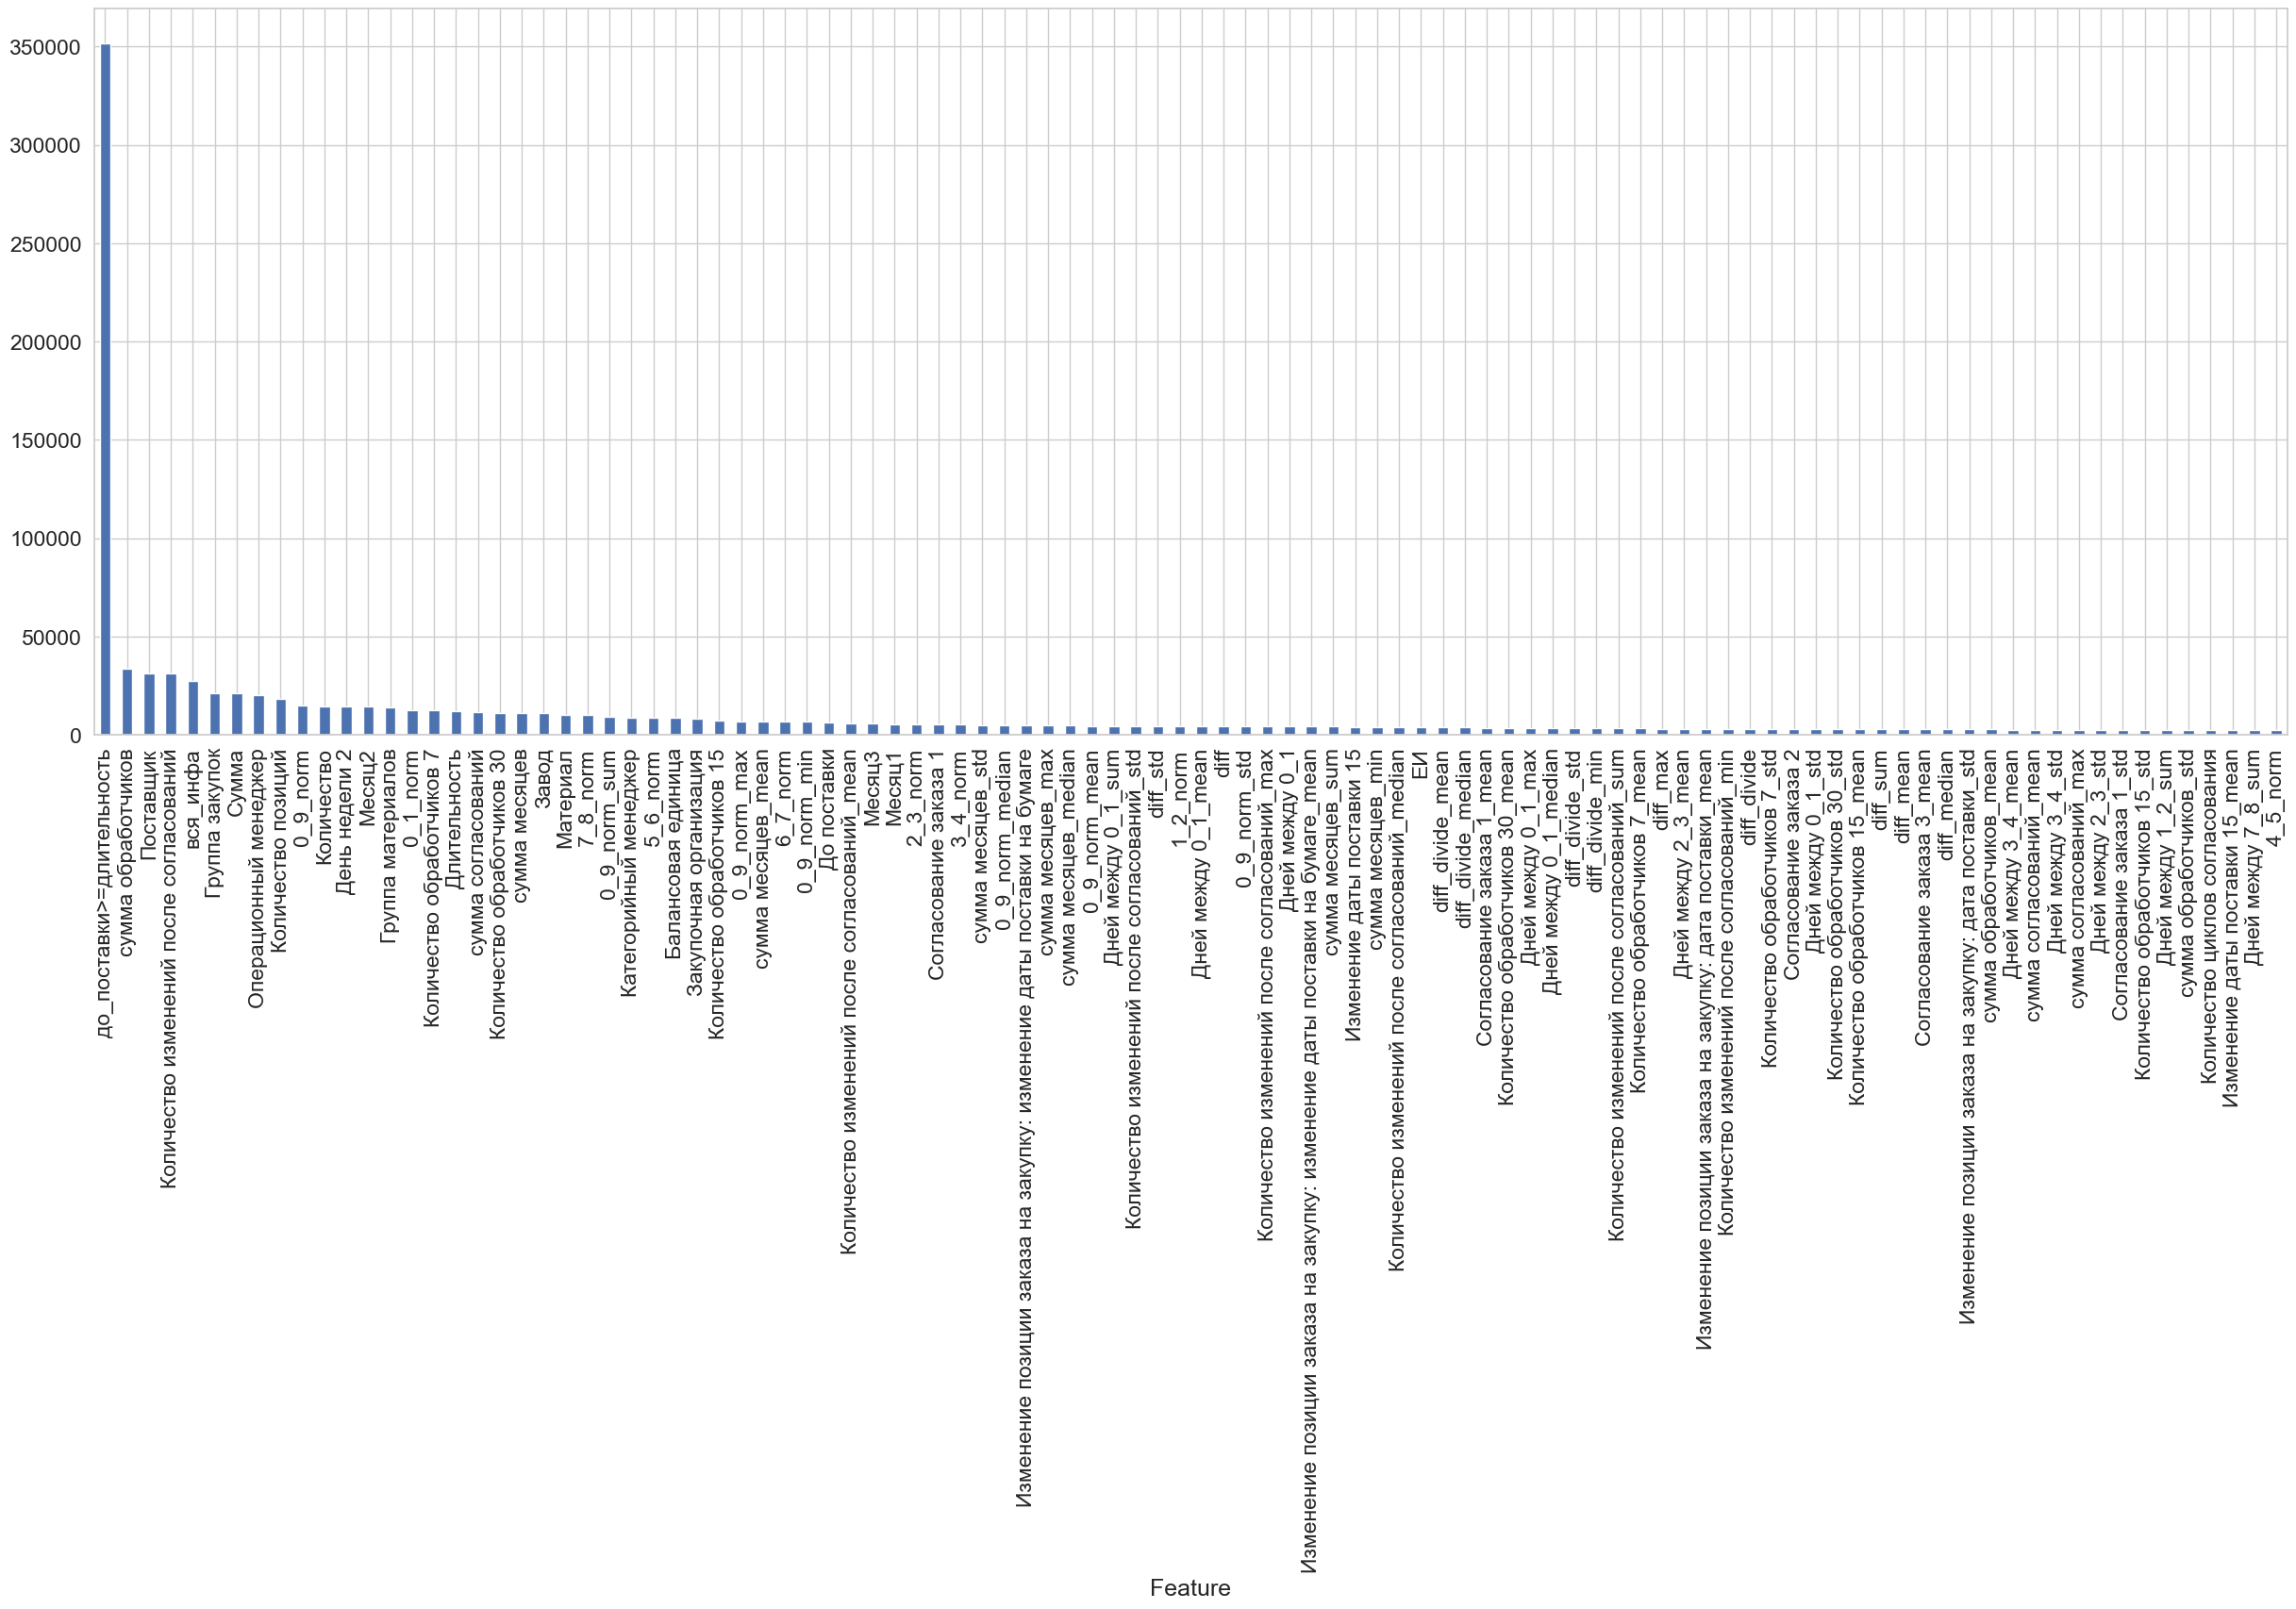

In [10]:
fast_fi = automl.model.get_feature_scores('fast').head(100)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

<AxesSubplot:xlabel='Feature'>

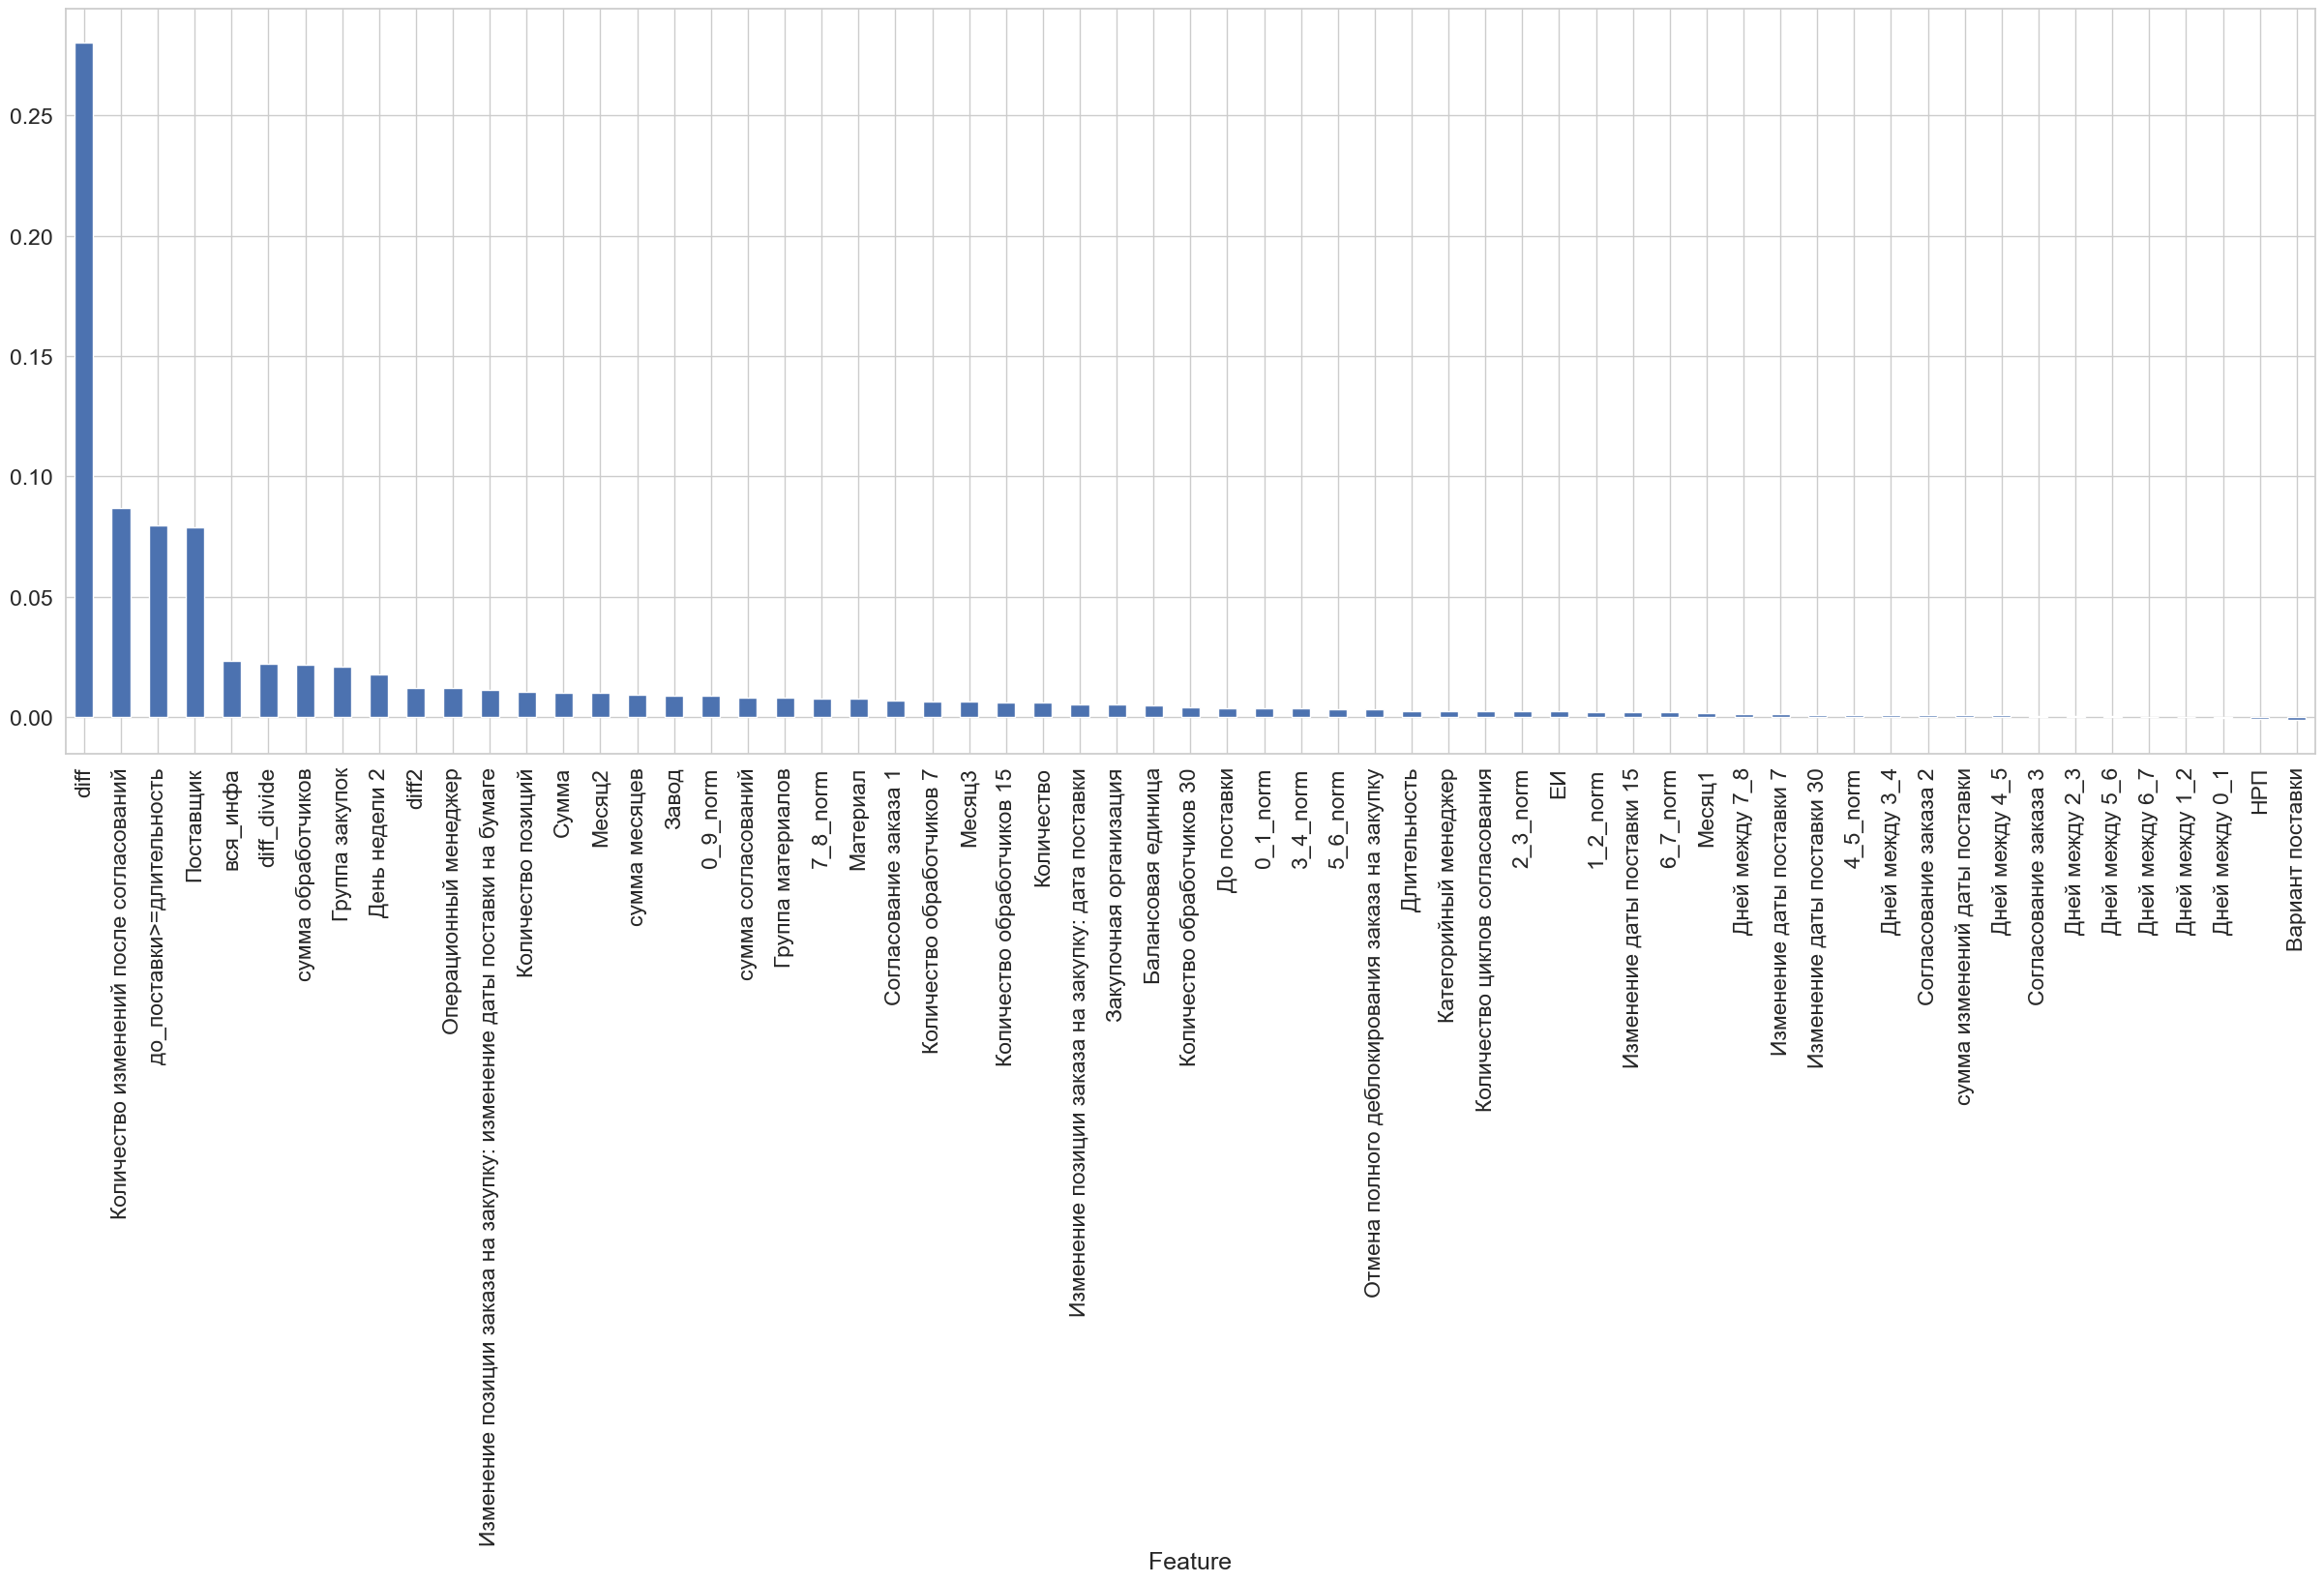

In [30]:
# Accurate feature importances calculation with detailed info (Permutation importances) -  can take long time to calculate
accurate_fi = automl.model.get_feature_scores('accurate', test_df, silent = True)
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

### MLJAR

Python package for AutoML on Tabular Data with Feature Engineering, Hyper-Parameters Tuning, Explanations and Automatic Documentation

In [ ]:
%pip -q install mljar-supervised

Подробнее можно посмотреть здесь: 
https://www.kaggle.com/code/remekkinas/tps-06-eda-mljar-automl-detailed-optuna/notebook

AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'mix_encoding', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']

In [7]:
# mljar
from supervised.automl import AutoML

import catboost
import lightgbm
import xgboost

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from joblib import load, dump

In [8]:
# main_df = main_df.fillna(-1).replace(np.inf, 0).replace(-np.inf, 0)
# main_test_df = main_test_df.fillna(-1).replace(np.inf, 0).replace(-np.inf, 0)

# fillna may resolve the error with category columns

for column in categorical_cols + ['вся_инфа']:
    main_df[column] = main_df[column].astype('object')

train_df, test_df = train_test_split(main_df, test_size=0.1, stratify=main_df['y'], shuffle=True, random_state=42)

Обучаем MLJAR в режиме 'Compete' с кросс-валидацией на 5 фолдов

In [53]:
%rm -rf /Users/nikitaromanov/Downloads/fifth_task_aiijc/models/mljar
%mkdir /Users/nikitaromanov/Downloads/fifth_task_aiijc/models/mljar

RESULTS_PATH = '/Users/nikitaromanov/Downloads/fifth_task_aiijc/models/mljar'

cv = {"validation_type": "kfold",
          "k_folds": 5,
          "shuffle": True,
          "stratify": True,
          "random_seed": 42}

automl = AutoML(results_path=RESULTS_PATH,
                mode="Compete",
                ml_task='auto',
                algorithms=['CatBoost','LightGBM', 'Xgboost'],
                train_ensemble=True,
                stack_models=True,
                features_selection=True,
                mix_encoding=True,
                eval_metric='f1',
                validation_strategy=cv,
                golden_features=40, # int or bool
                random_state=42,
                start_random_models=4,
                total_time_limit=60 * 60*8,
                #model_time_limit=30,
                #optuna_time_budget=60,
                hill_climbing_steps=2,
                top_models_to_improve=4
                )

automl.fit(train_df.drop('y', axis=1), train_df['y'])

AutoML directory: /Users/nikitaromanov/Downloads/fifth_task_aiijc/models/mljar
The task is binary_classification with evaluation metric f1
AutoML will use algorithms: ['CatBoost', 'LightGBM', 'Xgboost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'mix_encoding', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 3 models
1_Default_LightGBM f1 0.758053 trained in 856.72 seconds
2_Default_Xgboost f1 0.754625 trained in 861.89 seconds
3_Default_CatBoost f1 0.784213 trained in 770.43 seconds
* Step not_so_random will try to check up to 9 models
7_LightGBM f1 0.77974 trained in 724.6 seconds
4_Xgboost f1 0.750463 trained in 625.57 seconds
10_CatBoost f1 0.7855

AutoML(algorithms=['CatBoost', 'LightGBM', 'Xgboost'], eval_metric='f1',
       features_selection=True, golden_features=40, hill_climbing_steps=2,
       mix_encoding=True, mode='Compete', random_state=42,
       results_path='/Users/nikitaromanov/Downloads/fifth_task_aiijc/models/mljar',
       stack_models=True, start_random_models=4, top_models_to_improve=4,
       total_time_limit=28800,
       validation_strategy={'k_folds': 5, 'random_seed': 42, 'shuffle': True,
                            'stratify': True, 'validation_type': 'kfold'})

In [58]:
preds = automl.predict_proba(test_df.iloc[:5000])[:, 1]
a = [
    metrics.f1_score(test_df.iloc[:5000]['y'], [int(k > x / 100) for k in preds], average='macro')
    for x in range(100)
]
print(max(a), a.index(max(a)) / 100)

print('ROC-AUC:', metrics.roc_auc_score(test_df.iloc[:5000]['y'], preds)) # 0.463

0.8372093023255814 0.35
ROC-AUC: 0.9814941030239446


In [59]:
metrics.f1_score(test_df.iloc[:5000]['y'], automl.predict(test_df.iloc[:5000]), average='macro')

0.9030895391983432

In [55]:
# main_test_df.drop('вся_инфа', axis=1, inplace=True)
for column in categorical_cols + ['вся_инфа']:
    main_test_df[column] = main_test_df[column].astype('object')
submission = pd.read_csv('/Users/nikitaromanov/Downloads/fifth_task_aiijc/74abd23d767d00a2fcc9a2cbe53bc4e7')
submission['value'] = (automl.predict_proba(main_test_df)[:, 1] > a.index(max(a)) / 100)*1
submission.to_csv('sub.csv', index=False)

### PHIK

Phi_K - это новый и практичный коэффициент корреляции, основанный на нескольких уточнениях теста гипотезы Пирсона о независимости двух переменных.

Объединенные характеристики Phi_K формируют преимущество перед существующими коэффициентами. Во-первых, он работает последовательно между категориальными, порядковыми и интервальными переменными. Во-вторых, он фиксирует нелинейную зависимость. В-третьих, он возвращается к коэффициенту корреляции Пирсона в случае двумерного нормального распределения входных данных. Это полезные функции при изучении корреляционной матрицы переменных со смешанными типами.

Подробнее: https://phik.readthedocs.io/en/latest/

Смотрим PHIK на небольшой выборке

In [ ]:
phk_df = train_df[train_df.columns[train_df.columns.to_list().index('y'):]]
phik_overview = pd.concat([phk_df[phk_df.y == 1].iloc[:2000], phk_df[phk_df.y == 0].iloc[:2000]]).phik_matrix(interval_cols=[i for i in phk_df.columns if i not in categorical_cols and i != 'y']).round(3).sort_values('y')

# plot_correlation_matrix(phik_overview.values,
#                         x_labels=phik_overview.columns,
#                         y_labels=phik_overview.index,
#                         vmin=0, vmax=1, color_map="Greens",
#                         title=r"correlation $\phi_K$",
#                         fontsize_factor=0.8, figsize=(20, 12))
# plt.tight_layout()

In [66]:
phik_overview.sort_values('y', ascending=False).head(50)

,y,до_поставки>=длительность,diff,diff2,0_1_norm,1_2_norm,2_3_norm,3_4_norm,4_5_norm,5_6_norm,6_7_norm,7_8_norm,0_9_norm,Длительность_mean,Длительность_median,Длительность_std,Длительность_min,Длительность_max,Длительность_sum,Длительность_count,До поставки_mean,До поставки_median,До поставки_std,До поставки_min,До поставки_max,До поставки_sum,До поставки_count,Месяц1_mean,Месяц1_median,Месяц1_std,Месяц1_min,Месяц1_max,Месяц1_sum,Месяц1_count,Месяц2_mean,Месяц2_median,Месяц2_std,Месяц2_min,Месяц2_max,Месяц2_sum,Месяц2_count,Месяц3_mean,Месяц3_median,Месяц3_std,Месяц3_min,Месяц3_max,Месяц3_sum,Месяц3_count,День недели 2_mean,День недели 2_median,День недели 2_std,День недели 2_min,День недели 2_max,День недели 2_sum,День недели 2_count,Сумма_mean,Сумма_median,Сумма_std,Сумма_min,Сумма_max,Сумма_sum,Сумма_count,Количество позиций_mean,Количество позиций_median,Количество позиций_std,Количество позиций_min,Количество позиций_max,Количество позиций_sum,Количество позиций_count,Количество_mean,Количество_median,Количество_std,Количество_min,Количество_max,Количество_sum,Количество_count,Количество обработчиков 7_mean,Количество обработчиков 7_median,Количество обработчиков 7_std,Количество обработчиков 7_min,Количество обработчиков 7_max,Количество обработчиков 7_sum,Количество обработчиков 7_count,Количество обработчиков 15_mean,Количество обработчиков 15_median,Количество обработчиков 15_std,Количество обработчиков 15_min,Количество обработчиков 15_max,Количество обработчиков 15_sum,Количество обработчиков 15_count,Количество обработчиков 30_mean,Количество обработчиков 30_median,Количество обработчиков 30_std,Количество обработчиков 30_min,Количество обработчиков 30_max,Количество обработчиков 30_sum,Количество обработчиков 30_count,Согласование заказа 1_mean,Согласование заказа 1_median,Согласование заказа 1_std,Согласование заказа 1_min,Согласование заказа 1_max,Согласование заказа 1_sum,Согласование заказа 1_count,Согласование заказа 2_mean,Согласование заказа 2_median,Согласование заказа 2_std,Согласование заказа 2_min,Согласование заказа 2_max,Согласование заказа 2_sum,Согласование заказа 2_count,Согласование заказа 3_mean,Согласование заказа 3_median,Согласование заказа 3_std,Согласование заказа 3_min,Согласование заказа 3_max,Согласование заказа 3_sum,Согласование заказа 3_count,Изменение даты поставки 7_mean,Изменение даты поставки 7_median,Изменение даты поставки 7_std,Изменение даты поставки 7_min,Изменение даты поставки 7_max,Изменение даты поставки 7_sum,Изменение даты поставки 7_count,Изменение даты поставки 15_mean,Изменение даты поставки 15_median,Изменение даты поставки 15_std,Изменение даты поставки 15_min,Изменение даты поставки 15_max,Изменение даты поставки 15_sum,Изменение даты поставки 15_count,Изменение даты поставки 30_mean,Изменение даты поставки 30_median,Изменение даты поставки 30_std,Изменение даты поставки 30_min,Изменение даты поставки 30_max,Изменение даты поставки 30_sum,Изменение даты поставки 30_count,Отмена полного деблокирования заказа на закупку_mean,Отмена полного деблокирования заказа на закупку_median,Отмена полного деблокирования заказа на закупку_std,Отмена полного деблокирования заказа на закупку_min,Отмена полного деблокирования заказа на закупку_max,Отмена полного деблокирования заказа на закупку_sum,Отмена полного деблокирования заказа на закупку_count,Изменение позиции заказа на закупку: изменение даты поставки на бумаге_mean,Изменение позиции заказа на закупку: изменение даты поставки на бумаге_median,Изменение позиции заказа на закупку: изменение даты поставки на бумаге_std,Изменение позиции заказа на закупку: изменение даты поставки на бумаге_min,Изменение позиции заказа на закупку: изменение даты поставки на бумаге_max,Изменение позиции заказа на закупку: изменение даты поставки на бумаге_sum,Изменение позиции заказа на закупку: изменение даты поставки на бумаге_count,Изменение позиции заказа на закупку: дата поставки_mean,Изменение позиции заказа на закупку: дата поставки_media

### Featuretools

пробовали использовать библиотеку featuretools - Фреймворк python с открытым исходным кодом для автоматизированного создания признаков

In [ ]:
def use_featuretools(df):
    es = ft.EntitySet(id="production")
    es = es.add_dataframe(
    dataframe_name="all_fts",
    dataframe=df,
    index="index",
    logical_types={i:Categorical for i in categorical_cols})

    feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="all_fts",
    max_depth=1)

    feature_matrix = ft.selection.remove_highly_null_features(feature_matrix=feature_matrix)
    feature_matrix = ft.selection.remove_single_value_features(feature_matrix=feature_matrix)
    # feature_matrix = ft.selection.remove_highly_correlated_features(feature_matrix=feature_matrix)
    return feature_matrix

new_df = use_featuretools(train_df.drop('y', axis=1))
new_df['y'] = train_df['y']
new_df

### EDA

In [265]:
main_df.corr().sort_values(by='Поставщик', ascending=False)

,Поставщик,Материал,Категорийный менеджер,Операционный менеджер,Завод,Закупочная организация,Группа закупок,Балансовая единица,ЕИ,Группа материалов,Вариант поставки,НРП,Длительность,До поставки,Месяц1,Месяц2,Месяц3,День недели 2,Сумма,Количество позиций,Количество,Количество обработчиков 7,Количество обработчиков 15,Количество обработчиков 30,Согласование заказа 1,Согласование заказа 2,Согласование заказа 3,Изменение даты поставки 7,Изменение даты поставки 15,Изменение даты поставки 30,Отмена полного деблокирования заказа на закупку,Изменение позиции заказа на закупку: изменение даты поставки на бумаге,Изменение позиции заказа на закупку: дата поставки,Количество циклов согласования,Количество изменений после согласований,Дней между 0_1,Дней между 1_2,Дней между 2_3,Дней между 3_4,Дней между 4_5,Дней между 5_6,Дней между 6_7,Дней между 7_8,y,до_поставки>=длительность,до_поставки-длительность,вся_инфа_count,вся_инфа_sum,вся_инфа_mean
Поставщик,1.000000,0.177452,-0.013717,0.189371,0.155281,0.162086,0.343412,0.192399,0.072447,0.257648,0.060681,0.023523,0.053686,0.034112,0.023841,0.053222,0.024647,0.000542,0.296971,-0.209825,0.065996,0.006736,0.005608,0.005583,-0.147534,-0.103021,-0.133830,0.001366,0.001463,0.001797,-0.090990,0.026676,0.026975,-0.098083,0.011795,0.056627,-0.039605,0.003208,-0.034937,-0.019566,0.055209,0.035866,0.052943,0.060948,0.035233,0.049888,-0.123427,-0.126277,0.080522
Группа закупок,0.343412,0.184031,0.084753,0.191192,0.145670,0.157021,1.000000,0.187888,0.033349,0.276327,-0.037586,0.055666,0.068670,0.066551,0.016299,0.032052,0.021534,0.026816,0.300972,-0.169150,0.051072,0.036888,0.034434,0.031559,-0.065022,-0.048349,-0.044356,0.002608,0.002741,0.003100,-0.047100,0.007174,0.007912,-0.049659,0.022071,0.023610,-0.059928,0.015105,-0.009167,0.000431,0.038340,0.024840,0.053169,0.039582,0.018089,0.016614,-0.162080,-0.162413,0.052294
Сумма,0.296971,0.115090,0.179628,0.115417,0.094609,0.066107,0.300972,0.019634,0.112179,0.181745,-0.073171,0.069704,0.125108,0.128873,-0.011593,-0.001272,-0.014018,0.045647,1.000000,-0.098671,0.105775,0.161441,0.154999,0.150443,-0.065294,-0.087342,-0.049650,0.032198,0.032421,0.032647,-0.055700,0.048901,0.033244,-0.092604,0.050642,0.037612,0.004741,0.037237,0.009198,0.028768,0.058307,0.037253,0.070351,0.113177,0.058380,0.014564,-0.117714,-0.104214,0.138118
Группа материалов,0.257648,-0.029977,0.059187,0.143656,0.108197,0.080027,0.276327,0.123617,0.194028,1.000000,0.026072,-0.020454,-0.023539,-0.048832,0.009085,0.036428,0.008009,0.021779,0.181745,-0.154368,0.051038,0.039968,0.036964,0.034980,-0.044948,-0.009990,-0.021491,-0.033978,-0.033891,-0.033811,-0.003368,-0.012716,-0.024622,-0.006069,0.052791,0.037904,-0.085966,-0.006443,-0.021001,-0.017610,0.024605,0.009243,-0.002812,0.032000,-0.004266,0.047891,-0.173205,-0.174840,0.042277
Балансовая единица,0.192399,0.113504,-0.134606,0.131407,0.697116,0.697569,0.187888,1.000000,0.033154,0.123617,0.201663,-0.044712,-0.149933,-0.210634,0.048321,0.095802,0.066713,-0.034099,0.019634,-0.048652,0.013300,-0.304554,-0.307338,-0.311447,-0.286223,-0.119398,-0.331716,-0.124462,-0.124377,-0.124118,-0.077773,-0.165931,-0.105814,-0.114020,-0.042917,-0.059816,-0.093522,-0.077314,-0.099472,-0.105177,-0.001582,-0.014070,-0.031596,0.062071,0.000122,0.098267,-0.113708,-0.109113,0.082004
Операционный менеджер,0.189371,0.128927,0.193986,1.000000,0.043720,0.204962,0.191192,0.131407,0.000987,0.143656,0.092048,0.018664,0.059251,0.046958,-0.027839,0.034529,-0.017097,-0.001981,0.115417,-0.106963,0.013681,0.044549,0.051093,0.054991,-0.079430,-0.003068,-0.084826,0.015178,0.015499,0.016019,-0.035440,-0.025934,0.023264,-0.000069,0.001113,0.021344,-0.055674,0.018323,-0.027587,-0.011241,0.055284,0.043739,0.024290,-0.033188,-0.042133,0.035887,-0.160652,-0.164571,-0.043846
Материал,0.177452,1.000000,0.036578,0.128927,-0.016283,0.059353,0.184031,0.113504,-0.095825,-0.029977,-0.065147,0.194159,0.103919,0.105312,-0.008642,0.031821,0.013255,0.005188,0.115090,-0.113214,-0.028469,-0.022

/var/folders/6y/0mq5_kf5347crj38jj5xz8pr0000gn/T/ipykernel_6900/2368266117.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(main_df.corr().sort_values(by='y', ascending=False))


<AxesSubplot:>

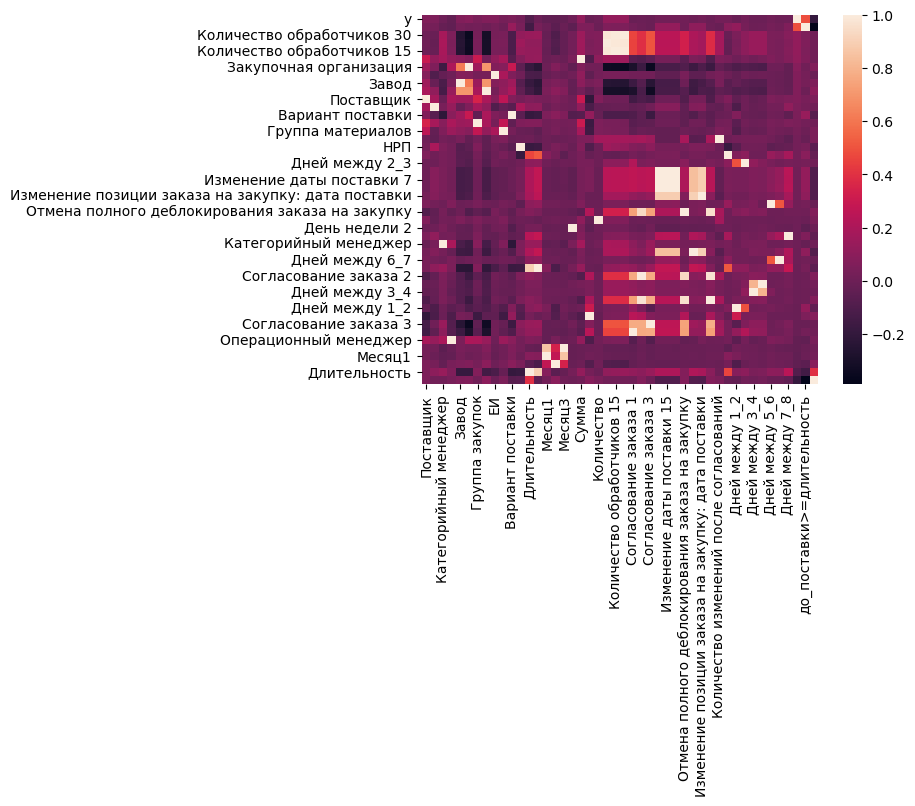

In [302]:
sns.heatmap(main_df.corr().sort_values(by='y', ascending=False))

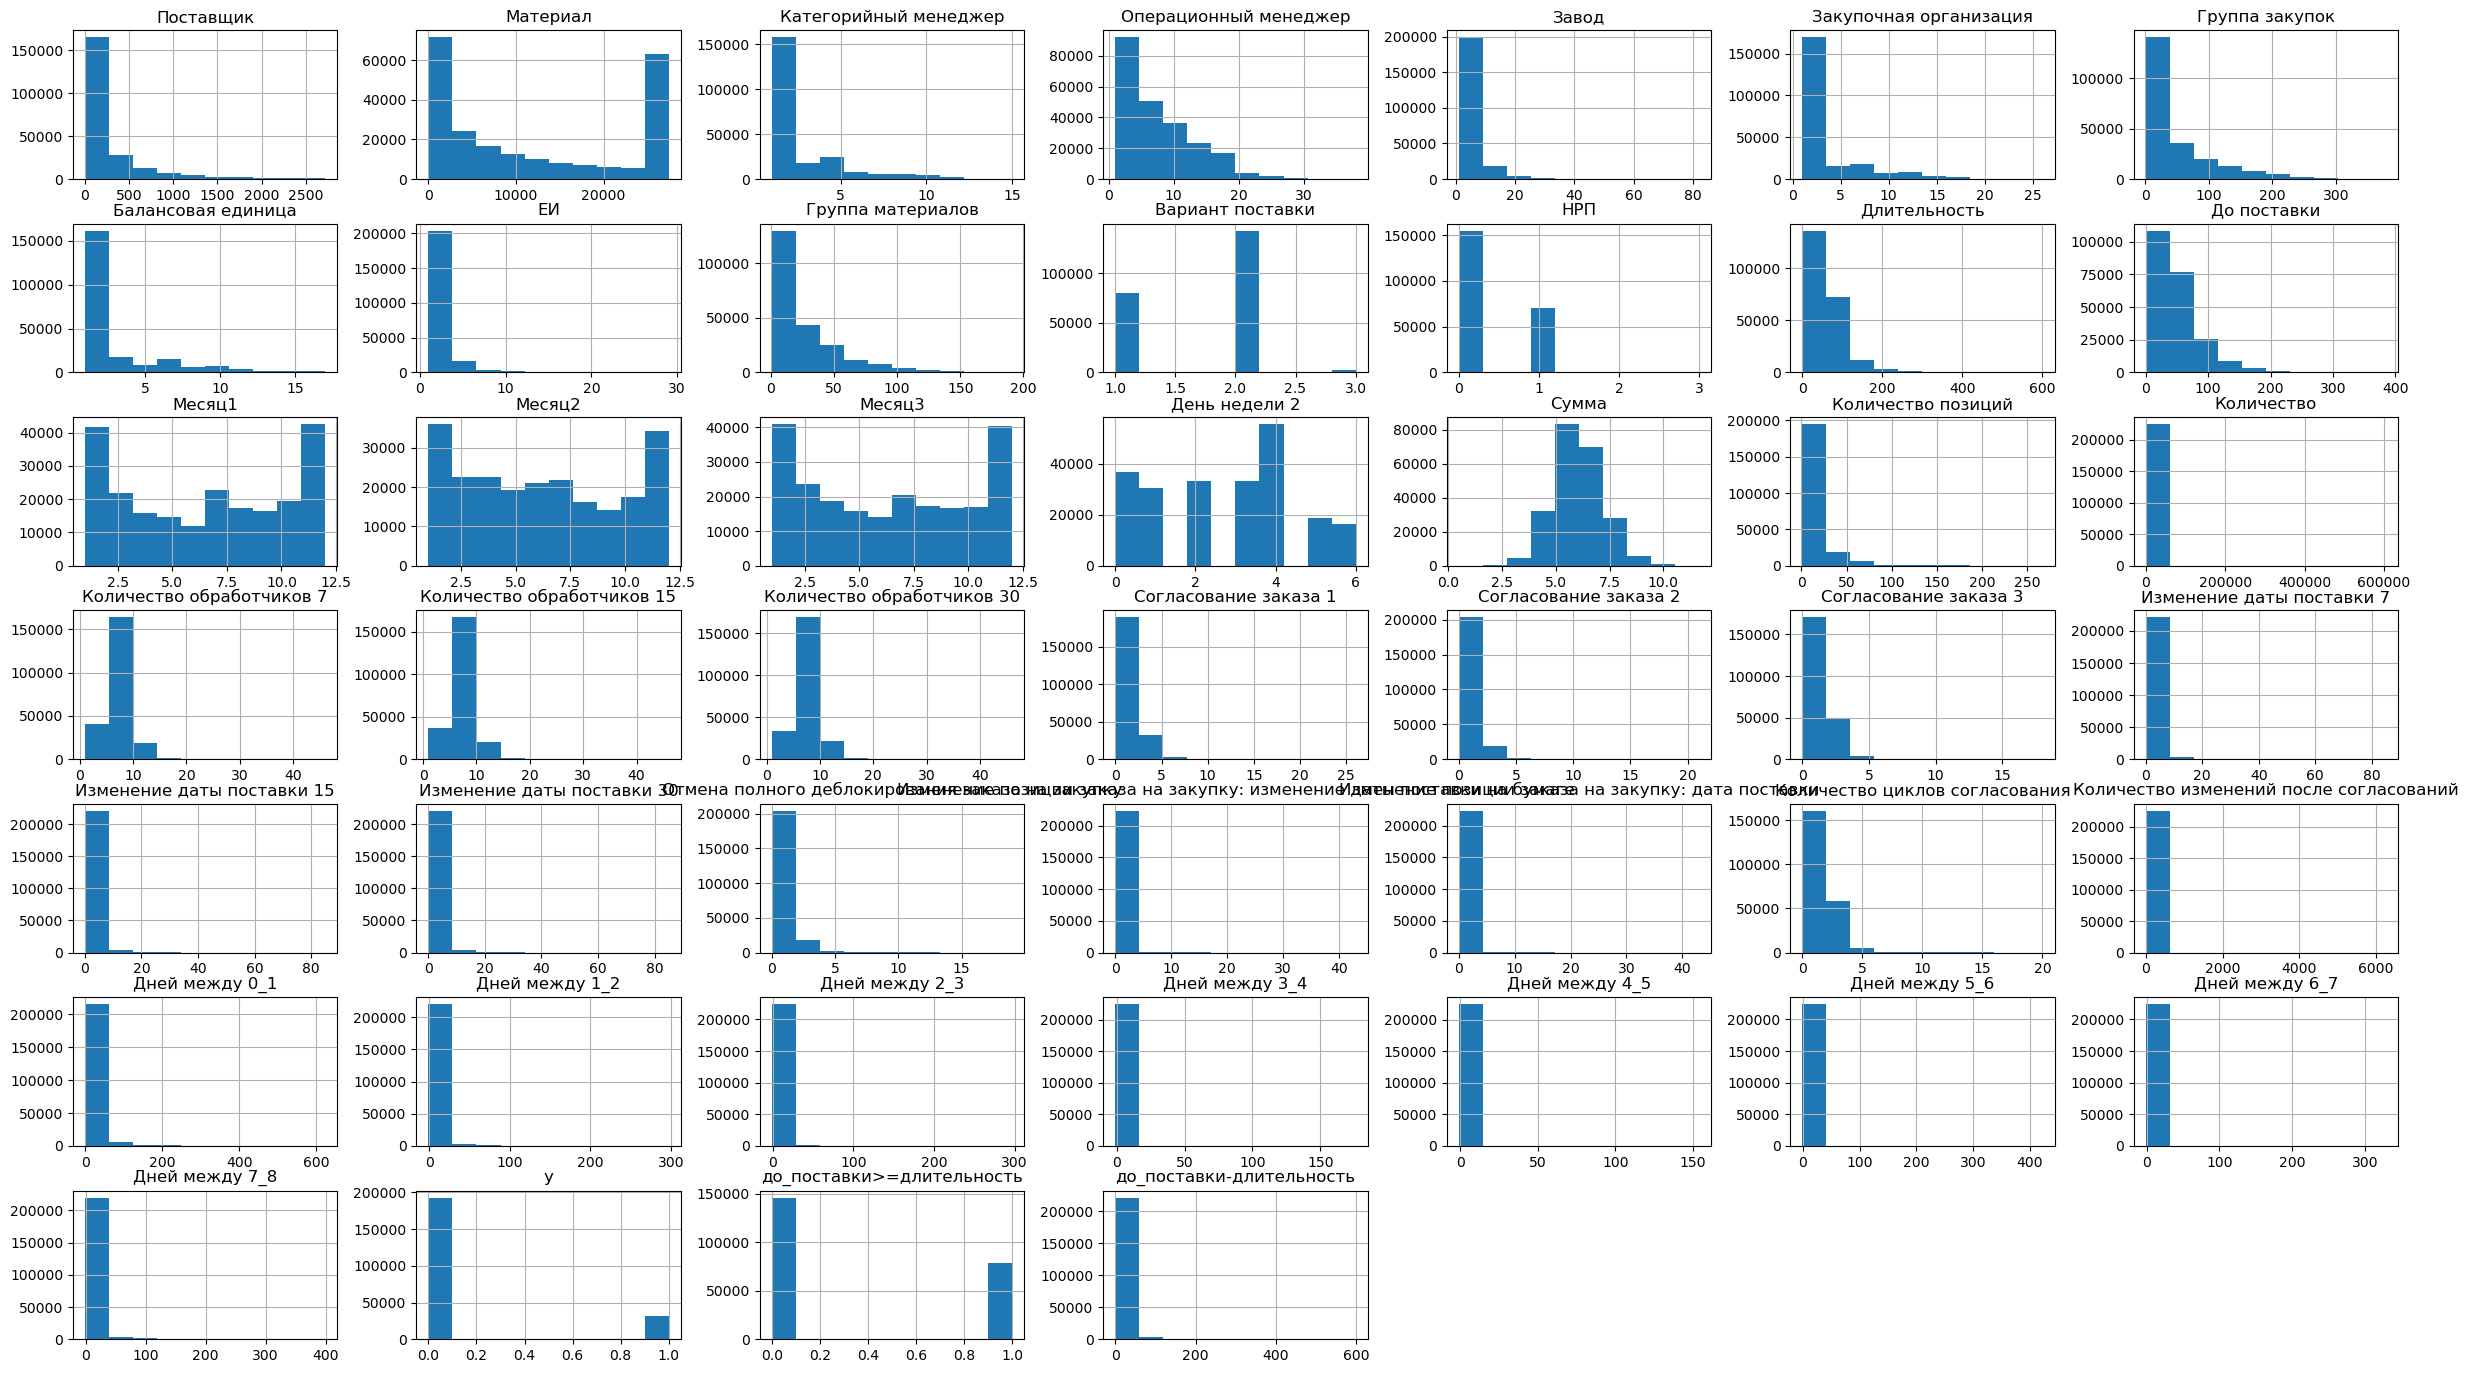

In [303]:
main_df.hist(figsize=(30, 17));

array([[<AxesSubplot:title={'center':'diff'}>]], dtype=object)

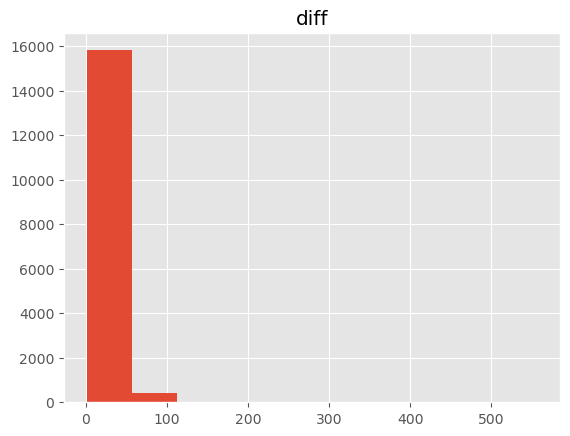

In [10]:
main_test_df[main_test_df['diff']>0].hist('diff')

In [45]:
import sklearn
sklearn.metrics.confusion_matrix(main_df['y'], main_df['до_поставки>=длительность'])

array([[143550,  49113],
       [  2665,  29672]])

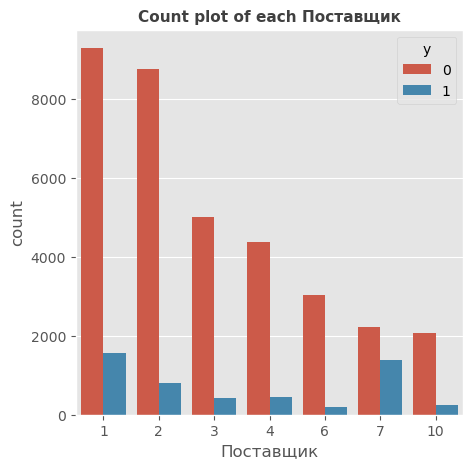

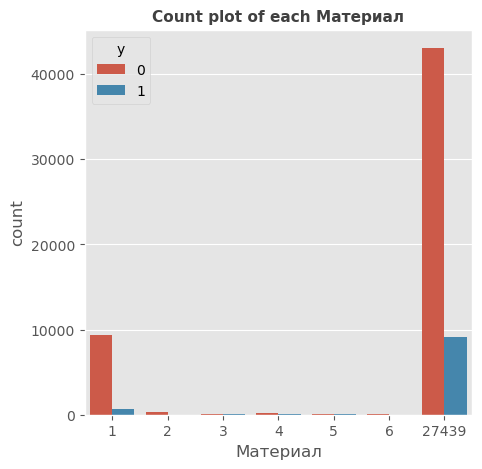

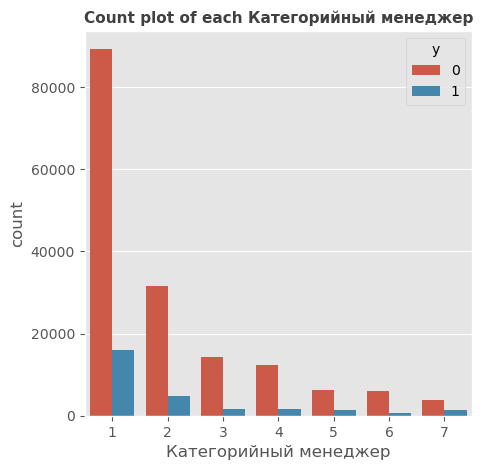

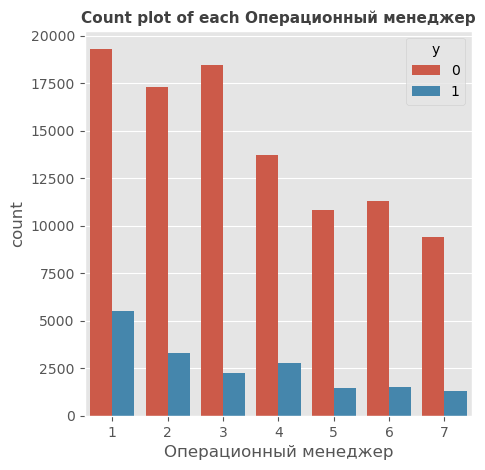

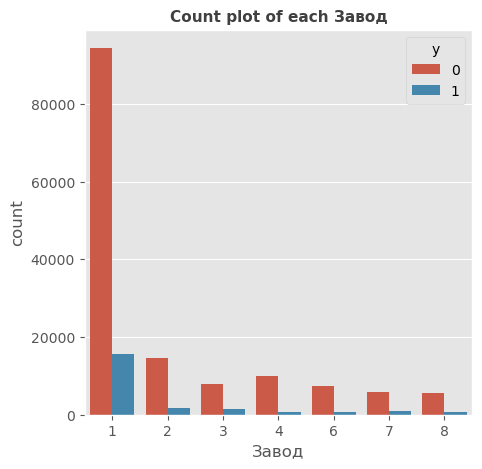

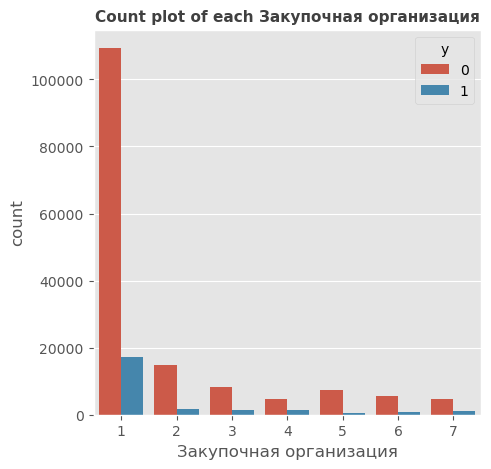

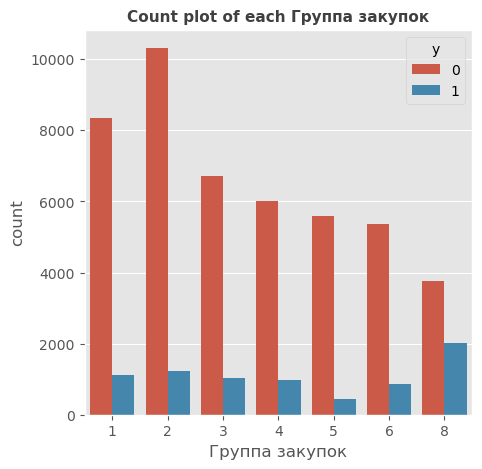

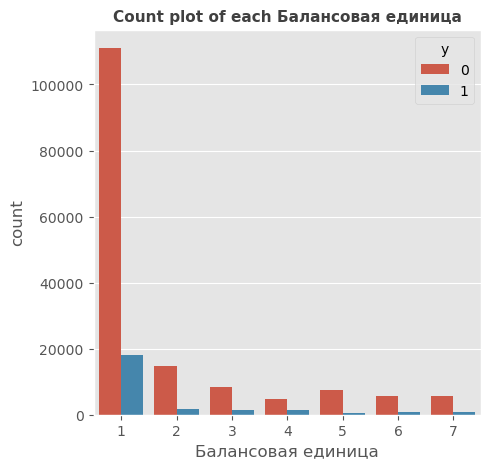

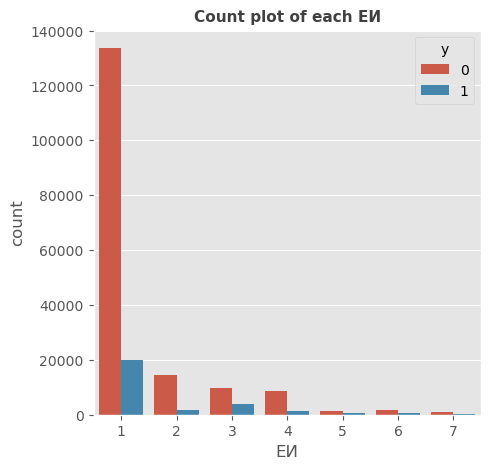

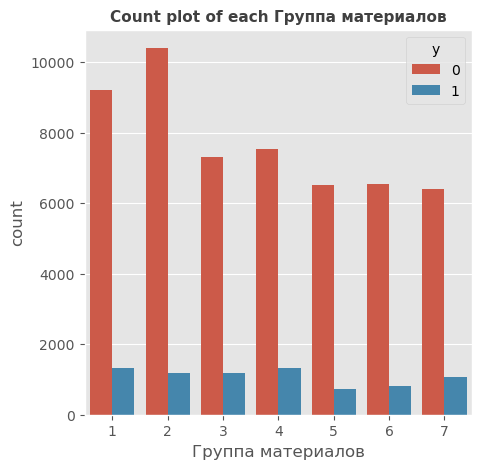

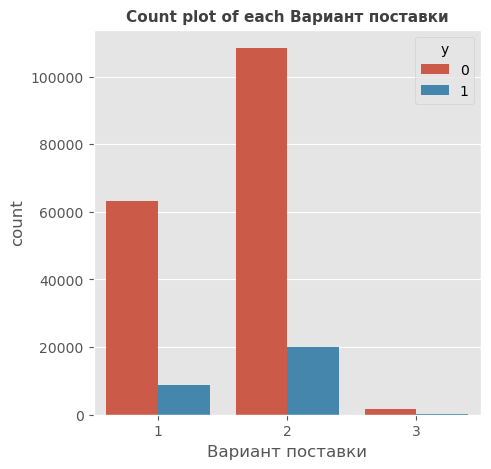

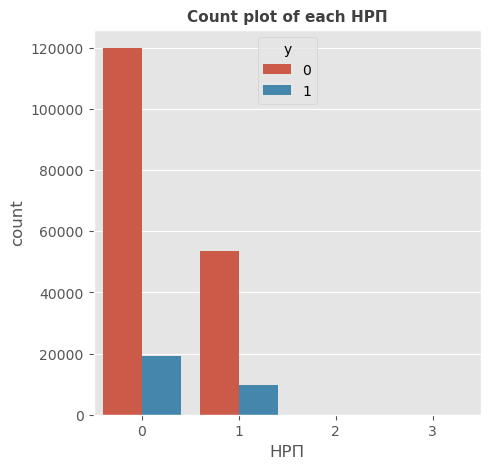

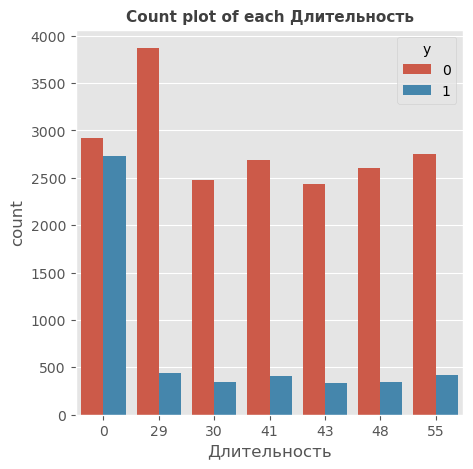

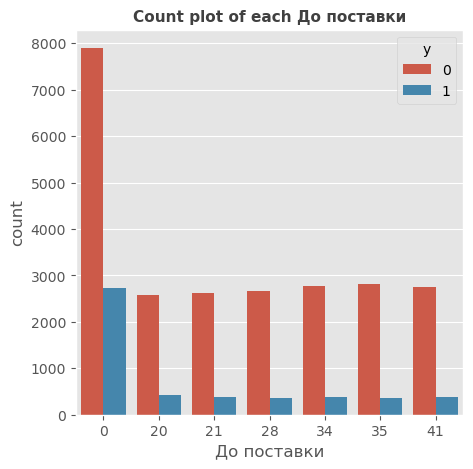

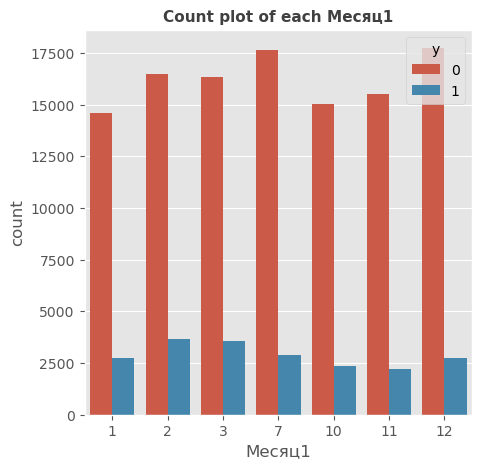

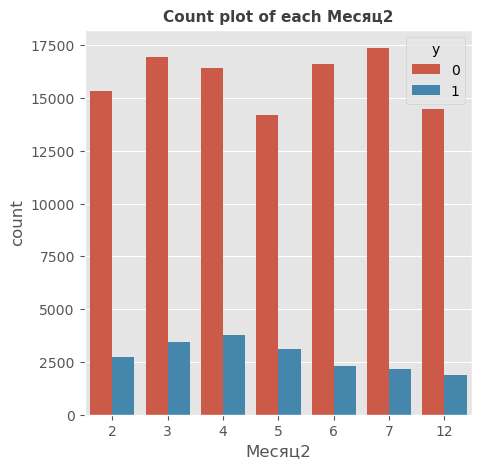

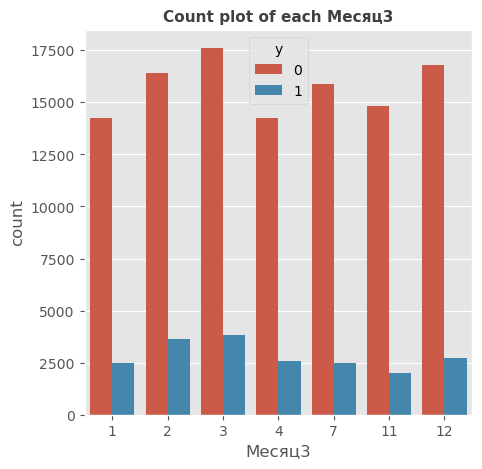

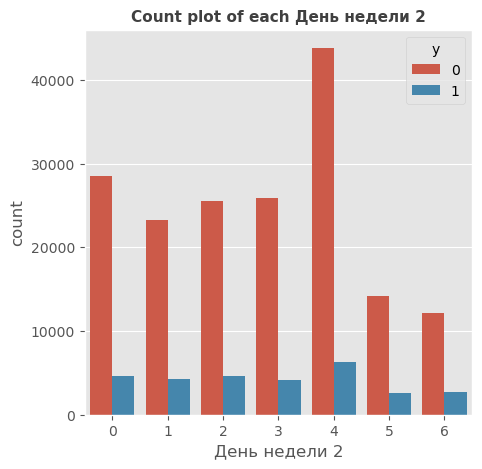

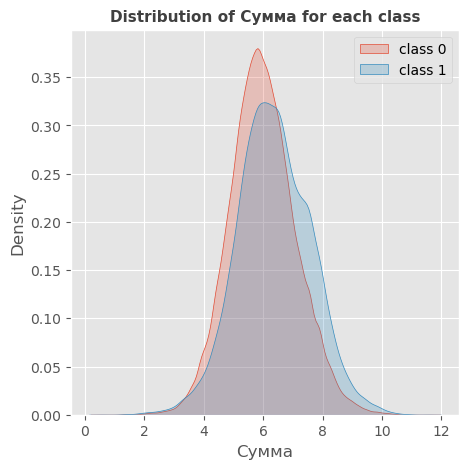

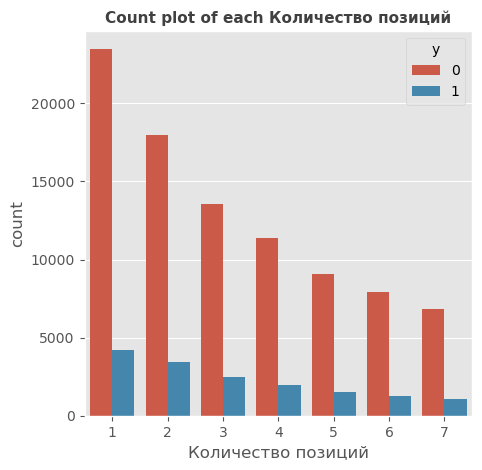

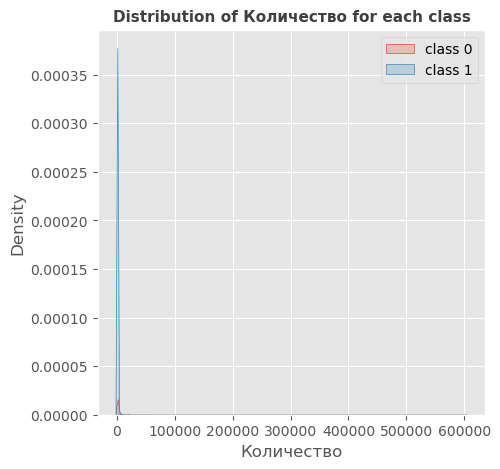

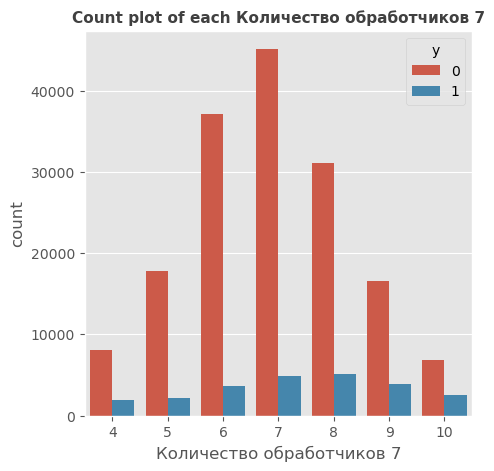

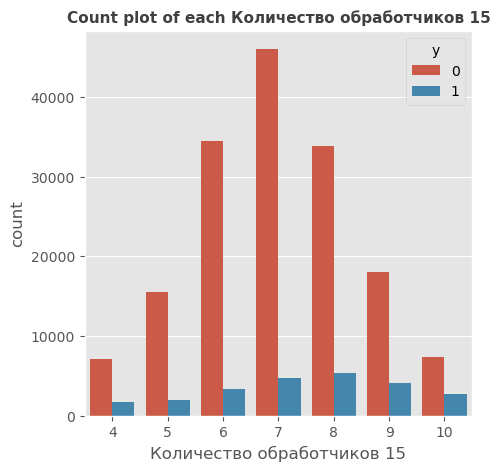

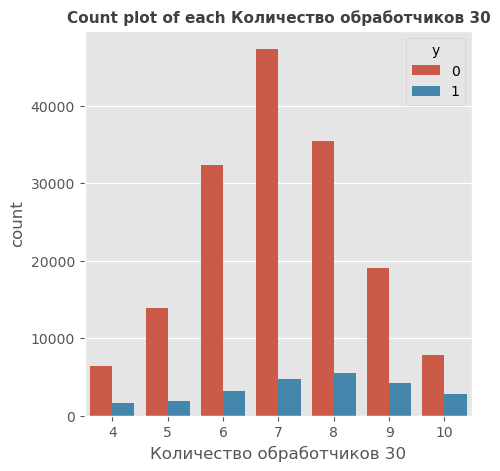

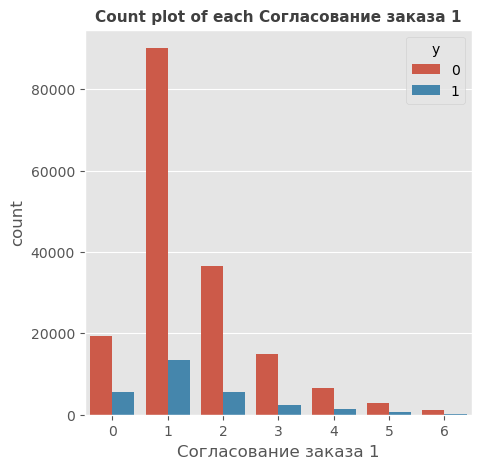

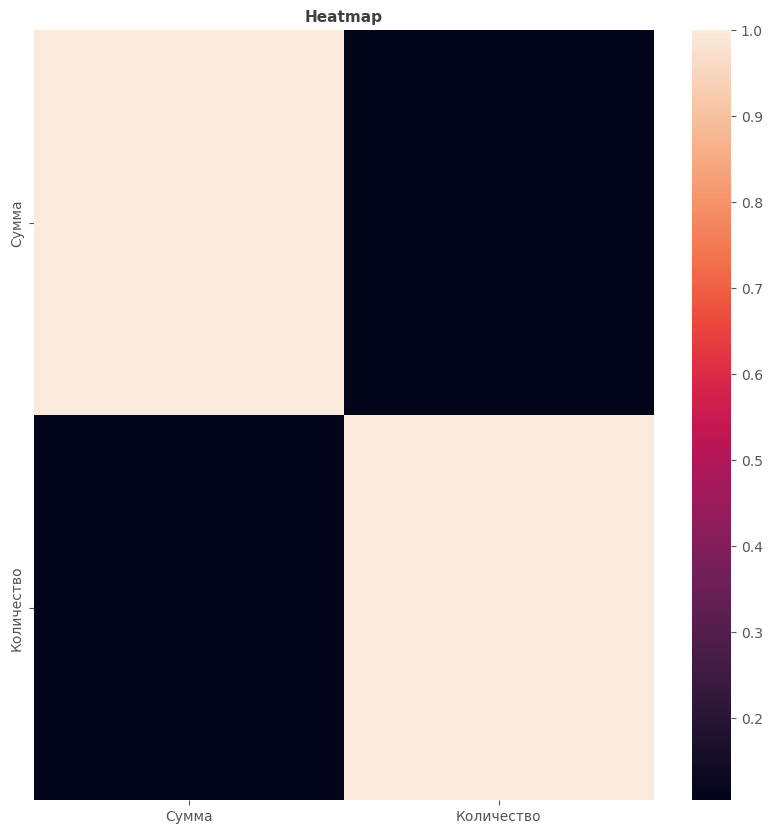

In [9]:
from supervised.preprocessing.eda import EDA
EDA.extensive_eda(train_df.drop('y', axis=1),train_df['y'],save_path="/Users/nikitaromanov/Downloads/fifth_task_aiijc/models/mljar/")

### Пока не используется

In [ ]:
import math
from six.moves import xrange
from catboost import Pool, CatBoostClassifier


class FocalLossObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        # approxes, targets, weights are indexed containers of floats
        # (containers with only __len__ and __getitem__ defined).
        # weights parameter can be None.
        # Returns list of pairs (der1, der2)
        gamma = 2.
        # alpha = 1.
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        exponents = []
        for index in xrange(len(approxes)):
            exponents.append(math.exp(approxes[index]))

        result = []
        for index in xrange(len(targets)):
            p = exponents[index] / (1 + exponents[index])

            if targets[index] > 0.0:
                der1 = -((1-p)**(gamma-1))*(gamma * math.log(p) * p + p - 1)/p
                der2 = gamma*((1-p)**gamma)*((gamma*p-1)*math.log(p)+2*(p-1))
            else:
                der1 = (p**(gamma-1)) * (gamma * math.log(1 - p) - p)/(1 - p)
                der2 = p**(gamma-2)*((p*(2*gamma*(p-1)-p))/(p-1)**2 + (gamma-1)*gamma*math.log(1 - p))

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))

        return result


'''
if __name__ == '__main__':
    cat_features = [0, 1]

    train_data = [[1, 4, 5, 6],
                [4, 5, 6, 7],
                [30, 40, 50, 60]]

    train_labels = [1, 1, 0]

    eval_data = [[3, 4, 4, 1],
                [1, 5, 5, 5],
                [31, 25, 60, 70]]

    # Initialize CatBoostClassifier with custom `loss_function`
    model = CatBoostClassifier(loss_function=FocalLossObjective(),
                            eval_metric="Logloss")
    # Fit model
    model.fit(train_data, train_labels)
    # Only prediction_type='RawFormulVal' allowed with custom `loss_function`
    preds_raw = model.predict(eval_data,
                            prediction_type='RawFormulaVal')

    print(preds_raw)
'''

Фичи, не давшие прироста точности (оставлены для ознакомления с историей экспериментов), запускать не нужно

In [ ]:
zavod_gb = pd.concat([main_df, main_test_df]).groupby('Завод')
zavod_info = zavod_gb['diff2'].agg(['count', lambda x: stats.mode(x)[0]])
zavod_info.columns = ['zavod_count', 'zavod_diff2_mode']

zavod_info['zavod_material'] = zavod_gb['Группа материалов'].agg(lambda x: stats.mode(x)[0])

zavod_info[['zavod_k_sogl_med', 'zavod_k_sogl_std', 'zavod_k_sogl_skew']] =  zavod_gb['Количество изменений после согласований'].agg(['median', 'std', 'skew'])
zavod_info[['zavod_diff_med', 'zavod_diff_std']] = zavod_gb['diff'].agg(['median', 'std'])
zavod_info[['zavod_summa_med', 'zavod_summa_std', 'zavod_summa_max']] = zavod_gb['Сумма'].agg(['median', 'std', 'max'])
zavod_info[['zavod_kolichestvo_med', 'zavod_kolichestvo_std', 'zavod_kolichestvo_max']] = zavod_gb['Количество'].agg(['median', 'std', 'max'])
zavod_info['zavod_nrp_mode'] = zavod_gb['НРП'].agg(lambda x: stats.mode(x)[0])
zavod_info['zavod_EI_mode'] = zavod_gb['ЕИ'].agg(lambda x: stats.mode(x)[0])
zavod_info[['zavod_k_pos_med', 'zavod_k_pos_std', 'zavod_k_pos_max', 'zavod_k_pos_min', 'zavod_k_pos_skew']] = \
zavod_gb['Количество позиций'].agg(['median', 'std', 'max', 'min', 'skew'])
for col in whynotcols:
    zavod_info[[f'zavod_{col}_{stat}' for stat in whynotstats]] = zavod_gb[col].agg(whynotstats)
categorical_cols.extend([
    'zavod_material', 'zavod_diff2_mode', 'zavod_nrp_mode', 'zavod_EI_mode'
])
zavod_info = zavod_info.fillna(0).copy()
zavod_info.head()

In [ ]:
manager1_gb = pd.concat([main_df, main_test_df]).groupby('Категорийный менеджер')
manager1_info = manager1_gb['diff2'].agg(['count', lambda x: stats.mode(x)[0]])
manager1_info.columns = ['manager1_count', 'manager1_diff2_mode']

manager1_info['manager1_material'] = manager1_gb['Группа материалов'].agg(lambda x: stats.mode(x)[0])

manager1_info[['manager1_k_sogl_med', 'manager1_k_sogl_std', 'manager1_k_sogl_skew']] =  manager1_gb['Количество изменений после согласований'].agg(['median', 'std', 'skew'])
manager1_info[['manager1_diff_med', 'manager1_diff_std']] = manager1_gb['diff'].agg(['median', 'std'])
manager1_info[['manager1_summa_med', 'manager1_summa_std', 'manager1_summa_max']] = manager1_gb['Сумма'].agg(['median', 'std', 'max'])
manager1_info[['manager1_kolichestvo_med', 'manager1_kolichestvo_std', 'manager1_kolichestvo_max']] = manager1_gb['Количество'].agg(['median', 'std', 'max'])
manager1_info['manager1_nrp_mode'] = manager1_gb['НРП'].agg(lambda x: stats.mode(x)[0])
manager1_info['manager1_EI_mode'] = manager1_gb['ЕИ'].agg(lambda x: stats.mode(x)[0])
manager1_info[['manager1_k_pos_med', 'manager1_k_pos_std', 'manager1_k_pos_max', 'manager1_k_pos_min', 'manager1_k_pos_skew']] = manager1_gb['Количество позиций'].agg(['median', 'std', 'max', 'min', 'skew'])
for col in whynotcols:
    manager1_info[[f'manager1_{col}_{stat}' for stat in whynotstats]] = manager1_gb[col].agg(whynotstats)
categorical_cols.extend([
    'manager1_material', 'manager1_diff2_mode', 'manager1_nrp_mode', 'manager1_EI_mode'
])
manager1_info = manager1_info.fillna(0).copy()
manager1_info.head()

In [ ]:
manager2_gb = pd.concat([main_df, main_test_df]).groupby('Операционный менеджер')
manager2_info = manager2_gb['diff2'].agg(['count', lambda x: stats.mode(x)[0]])
manager2_info.columns = ['manager2_count', 'manager2_diff2_mode']

manager2_info['manager2_material'] = manager2_gb['Группа материалов'].agg(lambda x: stats.mode(x)[0])

manager2_info[['manager2_k_sogl_med', 'manager2_k_sogl_std', 'manager2_k_sogl_skew']] =  manager2_gb['Количество изменений после согласований'].agg(['median', 'std', 'skew'])
manager2_info[['manager2_diff_med', 'manager2_diff_std']] = manager2_gb['diff'].agg(['median', 'std'])
manager2_info[['manager2_summa_med', 'manager2_summa_std', 'manager2_summa_max']] = manager2_gb['Сумма'].agg(['median', 'std', 'max'])
manager2_info[['manager2_kolichestvo_med', 'manager2_kolichestvo_std', 'manager2_kolichestvo_max']] = manager2_gb['Количество'].agg(['median', 'std', 'max'])
manager2_info['manager2_nrp_mode'] = manager2_gb['НРП'].agg(lambda x: stats.mode(x)[0])
manager2_info['manager2_EI_mode'] = manager2_gb['ЕИ'].agg(lambda x: stats.mode(x)[0])
manager2_info[['manager2_k_pos_med', 'manager2_k_pos_std', 'manager2_k_pos_max', 'manager2_k_pos_min', 'manager2_k_pos_skew']] = manager2_gb['Количество позиций'].agg(['median', 'std', 'max', 'min', 'skew'])
for col in whynotcols:
    manager2_info[[f'manager2_{col}_{stat}' for stat in whynotstats]] = manager2_gb[col].agg(whynotstats)
categorical_cols.extend([
    'manager2_material', 'manager2_diff2_mode', 'manager2_nrp_mode', 'manager2_EI_mode'
])
manager2_info = manager2_info.fillna(0).copy()
manager2_info.head()

In [ ]:
material_gb = pd.concat([main_df, main_test_df]).groupby('Материал')
material_info = material_gb['diff2'].agg(['count', lambda x: stats.mode(x)[0]])
material_info.columns = ['material_count', 'material_diff2_mode']

# material_info['material_material'] = material_gb['Группа материалов'].agg(lambda x: stats.mode(x)[0][0])

material_info[['material_k_sogl_med', 'material_k_sogl_std', 'material_k_sogl_skew']] =  material_gb['Количество изменений после согласований'].agg(['median', 'std', 'skew'])
material_info[['material_diff_med', 'material_diff_std']] = material_gb['diff'].agg(['median', 'std'])
material_info[['material_summa_med', 'material_summa_std', 'material_summa_max']] = material_gb['Сумма'].agg(['median', 'std', 'max'])
material_info[['material_kolichestvo_med', 'material_kolichestvo_std', 'material_kolichestvo_max']] = material_gb['Количество'].agg(['median', 'std', 'max'])
material_info['material_nrp_mode'] = material_gb['НРП'].agg(lambda x: stats.mode(x)[0])
material_info['material_EI_mode'] = material_gb['ЕИ'].agg(lambda x: stats.mode(x)[0])
material_info[['material_k_pos_med', 'material_k_pos_std', 'material_k_pos_max', 'material_k_pos_min', 'material_k_pos_skew']] = material_gb['Количество позиций'].agg(['median', 'std', 'max', 'min', 'skew'])
for col in whynotcols:
    material_info[[f'material_{col}_{stat}' for stat in whynotstats]] = material_gb[col].agg(whynotstats)
categorical_cols.extend([
     'material_diff2_mode', 'material_nrp_mode', 'material_EI_mode'
])
material_info = material_info.fillna(0).copy()
material_info.head()

In [ ]:
main_df = main_df.merge(zavod_info, on='Завод',how='left').merge(material_info, on='Материал',how='left').merge(manager1_info, on='Категорийный менеджер',how='left').merge(manager2_info, on='Операционный менеджер',how='left')
main_test_df = main_test_df.merge(zavod_info, on='Завод',how='left').merge(material_info, on='Материал',how='left').merge(manager1_info, on='Категорийный менеджер',how='left').merge(manager2_info, on='Операционный менеджер',how='left')

In [ ]:
train_df, test_df = train_test_split(main_df, test_size=0.1, random_state=42, stratify=main_df['y'])
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['y'])
train_df, data_df = train_test_split(train_df, test_size=0.4, random_state=42, stratify=train_df['y'])

def preprocess_df(cur_df, data_df):

    post_mat_zav_info = data_df.groupby('вся_инфа')['y'].agg(['count', 'sum', 'std'])
    post_mat_zav_info.columns = [f'вся_инфа_{x}' for x in post_mat_zav_info.columns]
    
    cur_df = cur_df.merge(post_mat_zav_info, on='вся_инфа', how='left')
    
    cur_df['вся_инфа_mean'] = (cur_df['вся_инфа_sum'] / cur_df['вся_инфа_count'])# .round()
    cur_df['вся_инфа_mean'].fillna(-1, inplace=True)
    
    cur_df.drop(['вся_инфа'], axis=1, inplace=True)
    
    return cur_df.fillna(-1)

train_df = preprocess_df(train_df, data_df)
valid_df = preprocess_df(valid_df, data_df)
test_df = preprocess_df(test_df, data_df)
main_test_df = preprocess_df(main_test_df, data_df)

#train_df = preprocess_df(train_df, pd.concat([data_df, test_df, valid_df]))
#valid_df = preprocess_df(valid_df, pd.concat([data_df, test_df, train_df]))
#test_df = preprocess_df(test_df, pd.concat([data_df, train_df, valid_df]))
#main_test_df = preprocess_df(main_test_df, main_df)

train_df

In [ ]:
def make_fts(df):
    s = df.groupby(by=['Поставщик'])['Количество изменений после согласований'].agg(['mean','std', 'sum', 'count', 'max'])
    df = df.merge(s, on=['Поставщик'], how='left')

    s = df.groupby(by=['Поставщик', 'Группа закупок'])['Количество изменений после согласований'].agg(['mean','std', 'sum', 'count', 'max'])
    df = df.merge(s, on=['Поставщик', 'Группа закупок'], how='left')

    s = df.groupby(by=['Поставщик', 'Материал', 'Группа закупок'])['до_поставки>=длительность'].agg(['mean','std', 'sum', 'count'])
    df = df.merge(s, on=['Поставщик', 'Материал', 'Группа закупок'], how='left')

    s = df.groupby(by=['Поставщик', 'до_поставки>=длительность'])['Количество изменений после согласований'].agg(['mean', 'median', 'std', 'min', 'max', 'sum', 'count'])
    df = df.merge(s, on=['Поставщик', 'до_поставки>=длительность'], how='left')

    s = df.groupby(by=['вся_инфа'])['до_поставки>=длительность'].agg(['mean', 'std', 'sum', 'count'])
    df = df.merge(s, on=['вся_инфа'], how='left')
    df['nzeros'] = df['count'] - df['sum']
    df.drop('вся_инфа', axis=1, inplace=True)

    return df

main_df = make_fts(main_df)